# **Evolution of Agriculture - Inputs, Environmental Impacts & Outputs**


#### *Some technical tools before beginning...*

In [1]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import geopandas as gpd
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import json
import pandas_bokeh
from scipy import stats
from bokeh.plotting import figure, output_file, save
pandas_bokeh.output_notebook()

import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

## **Introduction :**
World population is growing as never before and it is no secret. This increase has been made possible thanks to the progress that technologies have brought in the agriculture domain. The modern agriculture use lot of useful tools whether it is machinery, fertilizers, chemical pesticides, and so on. They made the humans able to harvest bigger areas, being more efficient, deal with illnesses and parasites, keep the food consumable longer.. Those revolution drastically changed the agriculture habits. Of course, progresses often have drawbacks and modern agriculture isn't exempted. One of the most common example is the increase in gas emissions. On the following graph, one can see the evolution of the global population and the evolution of gas emissions due to agriculture.


In [2]:
# Population evolution
population = pd.read_csv('../data/population.csv',sep=',',encoding='latin-1')
population = population[population.Element == 'Total Population - Both sexes']
world_pop = population[population.Country == 'World']
world_pop = world_pop.sort_values('Year')

In [3]:
# Emissions
emissions = pd.read_csv('../data/Emissions_AllAgriculture.csv',sep=',',encoding='latin-1')
#emissions.set_index('Year', inplace=True)
emissions.drop(['Domain', 'Area Code', 'Area', 'Item Code', 'Item', 'Element', 'Element Code', 'Year Code', 'Unit', 'Flag', 'Flag Description', 'Note'], axis=1, inplace=True)
emissions_total = emissions.groupby('Year').sum()
emissions_total.reset_index(inplace=True)

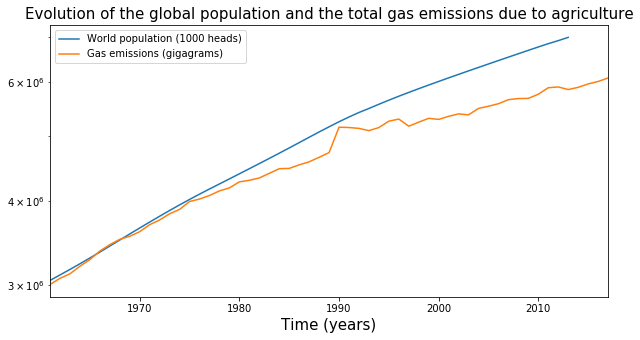

In [4]:
# Visualize the population growth, the production of food and their ratio
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(1,1,1)

world_pop.plot('Year', 'Value', logy=True, ax=ax1)
emissions_total.plot('Year', 'Value', logy=True, ax=ax1)
ax1.set_title('Evolution of the global population and the total gas emissions due to agriculture', fontsize=15)
ax1.set_xlabel('Time (years)', fontsize=15)
ax1.legend(['World population (1000 heads)', 'Gas emissions (gigagrams)'])
ax1.grid(axis='y', alpha=0.75)

fig.savefig("popvsgas", bbox_inches='tight')

One must be aware to check the units: The two curves don't represent the same thing here. However, the conclusion is that the gas emissions due to agriculture is roughly increasing collinearly with the global population until now. This is no good prediction for the future as we already feel the environmental consequences of our way of life. To have better clues on the topic, let's study more deeply the relationships between food production, use of fertilizers and environmental impact.

The datasets that are used in this study come from the Food and Agriculture Organization of the United Nations (FAO) website www.fao.org/home/fr/.

## **Part 1: The food production**

As a starting point, let's study the current world distribution of food production. Food production can be divided into several subsets, such as meat production, fruits/vegetables production, cereals production... To draw a global vision of the topic, let's study different big classes of food.  

#### **1) Meat production**

In [5]:
# Opening database
df_livestock_prim = pd.read_csv('../data/Production_LivestockPrimary_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')

To study the evolution of the quantity of meat production, we will use a dataset from the FAO database. We will first take a look at its structure. 

In [6]:
# Visualizing the first dataframe
livestock = df_livestock_prim.copy()
livestock.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1961,1961,1000 Head,4000.0,F
1,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1962,1962,1000 Head,4400.0,F
2,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1963,1963,1000 Head,4600.0,F
3,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1964,1964,1000 Head,4800.0,F
4,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1965,1965,1000 Head,5200.0,F


This dataframe contains information about the production of meat, eggs and milk products. It also contains several code that helps to refer to certain class of food. The items are already grouped by bigger families in the dataset. The 3 families we will keep on studying are  *Meat, Total* (item 1765), *Milk, Total* (item 1780) and *Eggs Primary* (item 1783). We only keep the production of those types of food.

In [7]:
# Keep only the meat, the eggs and the milk products
items = [1765, 1780, 1783]
livestock = livestock[livestock['Item Code'].isin(items)]

# Keep only the production
livestock_prod = livestock[livestock.Element == 'Production']

In [8]:
# Check if they are missing values
print("Missing values in livestock_prod:", livestock_prod.isnull().sum().sum())

Missing values in livestock_prod: 100


In [9]:
# Check that we have the same unit for similar products
print("Unit for the meat production:", livestock_prod[livestock_prod.Item == 'Meat, Total'].Unit.unique())
print("Unit for the eggs production:", livestock_prod[livestock_prod.Item == 'Eggs Primary'].Unit.unique())
print("Unit for the milk production:", livestock_prod[livestock_prod.Item == 'Milk,Total'].Unit.unique())

Unit for the meat production: ['tonnes']
Unit for the eggs production: ['tonnes']
Unit for the milk production: ['tonnes']


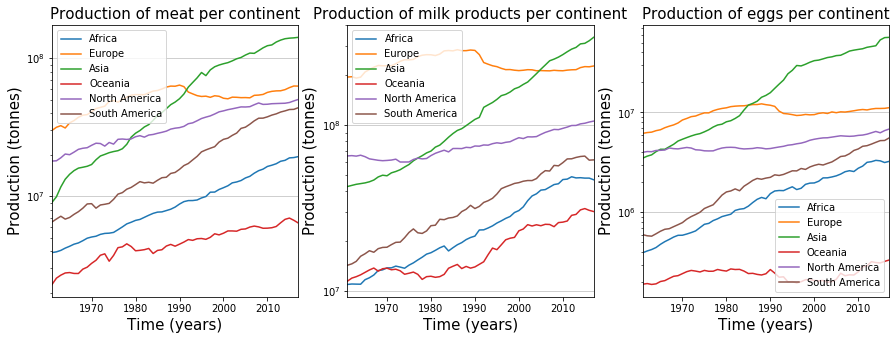

In [10]:
# Visualisation of the evolution of the quantity of livestocks per continent

def select_area(production, area):
    df = production[production.Area == area]
    meat = df[df['Item Code'] == 1765]
    milk = df[df['Item Code'] == 1780]
    eggs = df[df['Item Code'] == 1783]
    return  meat, milk, eggs

afr_meat, afr_milk, afr_eggs = select_area(livestock_prod, 'Africa')
eu_meat, eu_milk, eu_eggs   = select_area(livestock_prod, 'Europe')
as_meat, as_milk, as_eggs   = select_area(livestock_prod, 'Asia')
oc_meat, oc_milk, oc_eggs   = select_area(livestock_prod, 'Oceania')
nam_meat, nam_milk, nam_eggs = select_area(livestock_prod, 'Northern America')
sam_meat, sam_milk, sam_eggs = select_area(livestock_prod, 'South America')

fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(1,3,1)

# Production of meat
afr_meat.plot('Year', 'Value', logy=True, ax=ax1)
eu_meat.plot('Year', 'Value', logy=True, ax=ax1)
as_meat.plot('Year', 'Value', logy=True, ax=ax1)
oc_meat.plot('Year', 'Value', logy=True, ax=ax1)
nam_meat.plot('Year', 'Value', logy=True, ax=ax1)
sam_meat.plot('Year', 'Value', logy=True, ax=ax1)
ax1.set_title('Production of meat per continent', fontsize=15)
ax1.set_xlabel('Time (years)', fontsize=15)
ax1.set_ylabel('Production (tonnes)', fontsize=15)
ax1.legend(['Africa', 'Europe', 'Asia', 'Oceania', 'North America', 'South America'])
ax1.grid(axis='y', alpha=0.75)

ax2 = fig.add_subplot(1,3,2)

# Yield of milk products
afr_milk.plot('Year', 'Value', logy=True, ax=ax2)
eu_milk.plot('Year', 'Value', logy=True, ax=ax2)
as_milk.plot('Year', 'Value', logy=True, ax=ax2)
oc_milk.plot('Year', 'Value', logy=True, ax=ax2)
nam_milk.plot('Year', 'Value', logy=True, ax=ax2)
sam_milk.plot('Year', 'Value', logy=True, ax=ax2)
ax2.set_title('Production of milk products per continent', fontsize=15)
ax2.set_xlabel('Time (years)', fontsize=15)
ax2.set_ylabel('Production (tonnes)', fontsize=15)
ax2.legend(['Africa', 'Europe', 'Asia', 'Oceania', 'North America', 'South America'])
ax2.grid(axis='y', alpha=0.75)

ax3 = fig.add_subplot(1,3,3)

# Yield of eggs
afr_eggs.plot('Year', 'Value', logy=True, ax=ax3)
eu_eggs.plot('Year', 'Value', logy=True, ax=ax3)
as_eggs.plot('Year', 'Value', logy=True, ax=ax3)
oc_eggs.plot('Year', 'Value', logy=True, ax=ax3)
nam_eggs.plot('Year', 'Value', logy=True, ax=ax3)
sam_eggs.plot('Year', 'Value', logy=True, ax=ax3)
ax3.set_title('Production of eggs per continent', fontsize=15)
ax3.set_xlabel('Time (years)', fontsize=15)
ax3.set_ylabel('Production (tonnes)', fontsize=15)
ax3.legend(['Africa', 'Europe', 'Asia', 'Oceania', 'North America', 'South America'])
ax3.grid(axis='y', alpha=0.75)

The global evolution is increasing as expected. It seems that we have a missing value for the meat production at the year 2018. 
Let's try to visualize those graphs on a folium map. First, let's take a look at the distribution of the values.

Text(0.5, 1.0, 'Distribution of the values taken in livestock_prod')

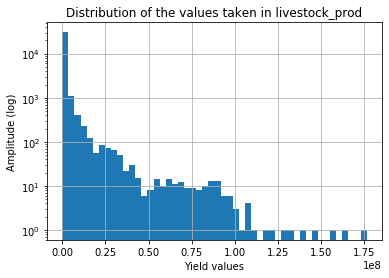

In [11]:
# We now want to study the stocks for each country
livestock_country = livestock_prod[livestock_prod['Area Code'] < 5000] # to get rid of the groups such as the continents

# Plot the distribution of the values taken in the row 'Value'
livestock_country.Value.hist(bins = 50, log=True)
plt.xlabel('Yield values')
plt.ylabel('Amplitude (log)')
plt.title('Distribution of the values taken in livestock_prod')

A logarithm scale seems appropriated for this case.

In [12]:
# Create a new column with the log value of each stock value
livestock_country['Log Value'] = livestock_country.Value.transform(lambda x:round(np.log(x)))
livestock_country['Log Value'] = livestock_country['Log Value'].replace(-np.inf, 0)

#### **Map preparation**

Now, we have to prepare the map with our json file 'countries.geo.json'. To handle the issue that some countries are referenced differently in the FAO database and in the GeoJson file, we replace by hand the concerned countries; It has been possible since a few countries were in that situation.

In [16]:
# Make sure that every country is labeled with the same name in the GeoJson file and in the dataframe
def replace_values_geojson(df):
    new_df = df
    new_df[new_df.Area == 'Russian Federation'] = df[df.Area == 'Russian Federation'].replace('Russian Federation', 'Russia')
    new_df[new_df.Area == 'Bolivia (Plurinational State of)'] = df[df.Area == 'Bolivia (Plurinational State of)'].replace('Bolivia (Plurinational State of)', 'Bolivia')
    new_df[new_df.Area == 'Venezuela (Bolivarian Republic of)'] = df[df.Area == 'Venezuela (Bolivarian Republic of)'].replace('Venezuela (Bolivarian Republic of)', 'Venezuela')
    new_df[new_df.Area == 'Côte d\'Ivoire'] = df[df.Area == 'Côte d\'Ivoire'].replace('Côte d\'Ivoire', 'Ivory Coast')
    new_df[new_df.Area == 'Congo'] = df[df.Area == 'Congo'].replace('Congo', 'Republic of the Congo')   
    new_df[new_df.Area == 'Republic of Moldova'] = df[df.Area == 'Republic of Moldova'].replace('Republic of Moldova', 'Moldova')
    new_df[new_df.Area == 'Syrian Arab Republic'] = df[df.Area == 'Syrian Arab Republic'].replace('Syrian Arab Republic', 'Syria')
    new_df[new_df.Area == 'Iran (Islamic Republic of)'] = df[df.Area == 'Iran (Islamic Republic of)'].replace('Iran (Islamic Republic of)', 'Iran')
    new_df[new_df.Area == 'Viet Nam'] = df[df.Area == 'Viet Nam'].replace('Viet Nam', 'Vietnam')
    new_df[new_df.Area == 'Lao People\'s Democratic Republic'] = df[df.Area == 'Lao People\'s Democratic Republic'].replace('Lao People\'s Democratic Republic', 'Laos')
    new_df[new_df.Area == 'Democratic People\'s Republic of Korea'] = df[df.Area == 'Democratic People\'s Republic of Korea'].replace('Democratic People\'s Republic of Korea', 'North Korea')
    new_df[new_df.Area == 'Republic of Korea'] = df[df.Area == 'Republic of Korea'].replace('Republic of Korea', 'South Korea')
    new_df[new_df.Area == 'Serbia'] = df[df.Area == 'Serbia'].replace('Serbia', 'Republic of Serbia')
    new_df[new_df.Area == 'The former Yugoslav Republic of Macedonia'] = df[df.Area == 'The former Yugoslav Republic of Macedonia'].replace('The former Yugoslav Republic of Macedonia', 'Macedonia')
    new_df[new_df.Area == 'China, Taiwan Province of'] = df[df.Area == 'China, Taiwan Province of'].replace('China, Taiwan Province of', 'Taiwan')
    return(new_df)

livestock_country = replace_values_geojson(livestock_country)
livestock_country.drop_duplicates(inplace=True)

In [17]:
# Read the GeoJson file as a geopandas dataframe
gdf = gpd.read_file("../countries.geo.json")
gdf.head()

,id,name,geometry
0,AFG,Afghanistan,"POLYGON ((61.21082 35.65007, 62.23065 35.27066..."
1,AGO,Angola,"POLYGON ((16.32653 -5.87747, 16.57318 -6.62265..."
2,ALB,Albania,"POLYGON ((20.59025 41.85540, 20.46317 41.51509..."
3,ARE,United Arab Emirates,"POLYGON ((51.57952 24.24550, 51.75744 24.29407..."
4,ARG,Argentina,"MULTIPOLYGON (((-65.50000 -55.20000, -66.45000..."


The geopanda dataframe has 3 columns, an id, a name and the geometry of the country. Some countries have different islands or disconnected regions, such as the United States and the Alsaka. To handle this, MultiPolygon geometries weren't supported here so we decided to create several rows having the same id and name and a different geometry. Now, we will preprocess the dataframe to keep only the useful information and the required format to plot our map.

In [18]:
# Keeping only the values related to a single product, here the meat
meat = livestock_country[livestock_country['Item Code'] == 1765]
meat.drop_duplicates(inplace=True)

# Drop useless columns
meat.drop(['Area Code', 'Item', 'Item Code', 'Element', 'Element Code', 'Year Code', 'Unit', 'Value', 'Flag'], axis=1, inplace=True)
meat = meat.rename(columns={'Area': 'name'})  # To have the same name for merging

meat.head()

,name,Year,Log Value
4040,Afghanistan,1961,11.770818
4041,Afghanistan,1962,11.792117
4042,Afghanistan,1963,11.842021
4043,Afghanistan,1964,11.876387
4044,Afghanistan,1965,11.919690


The required format to plot interactive maps with bokeh is a geodataframe with the information of the GeoJson file with one column per year containing the information to be plotted. The following function is to add a column year by year to the GeoJson file.

In [19]:
# Add one column per year containing the Log Value of the production of meat

years = range (1961, 2018)

for y in years:
    j = meat[meat.Year == y]
    j.drop('Year', axis=1, inplace=True)
    gdf = gdf.merge(j, on='name', how='left')
    gdf = gdf.rename(columns={'Log Value': 'Meat %d'%y})

gdf.head(3)

,id,name,geometry,Meat 1961,Meat 1962,Meat 1963,Meat 1964,Meat 1965,Meat 1966,Meat 1967,...,Meat 2008,Meat 2009,Meat 2010,Meat 2011,Meat 2012,Meat 2013,Meat 2014,Meat 2015,Meat 2016,Meat 2017
0,AFG,Afghanistan,"POLYGON ((61.21082 35.65007, 62.23065 35.27066...",11.770818,11.792117,11.842021,11.876387,11.919690,12.073741,12.123951,...,12.591539,12.625901,12.701257,12.723866,12.708664,12.682648,12.649389,12.618851,12.592168,12.586374
1,AGO,Angola,"POLYGON ((16.32653 -5.87747, 16.57318 -6.62265...",10.483438,10.514584,10.544394,10.649275,10.733109,10.775826,10.863355,...,12.176634,12.228367,12.287777,12.343854,12.400714,12.470723,12.523202,12.572357,12.562561,12.599846
2,ALB,Albania,"POLYGON ((20.59025 41.85540, 20.46317 41.51509...",10.142898,10.155024,10.126631,10.073230,10.135591,10.199882,10.390225,...,11.395470,11.410017,11.423438,11.444004,11.449986,11.469329,11.381004,11.399611,11.401457,11.406164


In [20]:
output_file("meat.html")

# Plot the production on an interactive map
slider_columns = ["Meat %d"%i for i in years]

meat_map = gdf.plot_bokeh(
            figsize = (900,600),
            simplify_shapes=10000,
            slider = slider_columns,
            slider_range = years,
            slider_name = 'Year',
            colormap = meat_colormap,
            hovertool_columns = ['id']+slider_columns,
            title='Meat production')

save(meat_map)

'/home/clelie/Bureau/EPFL/ADA/Projet/ada_project-ada_nakamura/to_be_sent/meat.html'

This map represents the production of meat in the world since 1961. Countries that are displayed in dark grey are countries for which no value is present in the FAO database. 
The production has increases a lot all around the world, and this production is linked to a bigger water conumption and crops to feed the animals. Let's then take a look at thos crops.

#### **2) Crops production**

A new dataset is used to study the production and the yield of crops. Let's visualize it and preprocess it.

In [13]:
df_prod_crops = pd.read_csv('../data/Production_Crops_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')
crops = df_prod_crops.copy()
crops.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0.0,F
1,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1976,1976,ha,5900.0,F
2,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1977,1977,ha,6000.0,F
3,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1978,1978,ha,6000.0,F
4,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1979,1979,ha,6000.0,F


The same structure is provided for this dataset. Grouped items exist and we will study the vegetables, the fruits, the roots.

In [28]:
crops_item = [1738, 1720, 1735]
crops = crops[crops['Item Code'].isin(crops_item)]

In [30]:
# Compute the log values
crops['Log Value'] = crops.Value.transform(lambda x:np.log(x))
crops['Log Value'] = crops['Log Value'].replace(-np.inf, 0)

A consistent measure of the efficiency of a country is its yield, expressed in hectograms of produced crops by hectares of harvested area. Let's vizualise the yield of fruits, vegetables and roots production since 1961.

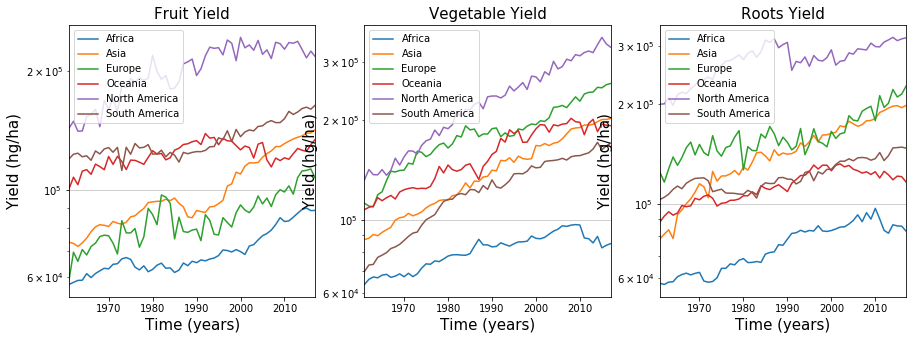

In [24]:
# Visualisation of the evolution of the quantity of crops per continent

def select_area(production, area):
    df = production[production.Area == area]
    fruit = df[df['Item Code'] == 1738]
    veggies = df[df['Item Code'] == 1735]
    roots = df[df['Item Code'] == 1720]
    return  fruit, veggies, roots

yield_crops = crops[crops.Element=='Yield']
yield_crops  = yield_crops.sort_values('Year')

afr_fruit, afr_veggies, afr_roots = select_area(yield_crops, 'Africa')
eu_fruit, eu_veggies, eu_roots   = select_area(yield_crops, 'Europe')
as_fruit, as_veggies, as_roots   = select_area(yield_crops, 'Asia')
oc_fruit, oc_veggies, oc_roots   = select_area(yield_crops, 'Oceania')
nam_fruit, nam_veggies, nam_roots = select_area(yield_crops, 'Northern America')
sam_fruit, sam_veggies, sam_roots = select_area(yield_crops, 'South America')

fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(1,3,1)

afr_fruit.plot('Year', 'Value', logy=True, ax=ax1)
as_fruit.plot('Year', 'Value', logy=True, ax=ax1)
eu_fruit.plot('Year','Value', logy=True, ax=ax1)
oc_fruit.plot('Year', 'Value', logy=True, ax=ax1)
nam_fruit.plot('Year', 'Value', logy=True, ax=ax1)
sam_fruit.plot('Year', 'Value', logy=True, ax=ax1)
ax1.set_title('Fruit Yield', fontsize=15)
ax1.set_xlabel('Time (years)', fontsize=15)
ax1.set_ylabel('Yield (hg/ha)', fontsize=15)
ax1.legend(['Africa', 'Asia', 'Europe', 'Oceania', 'North America', 'South America'])
ax1.grid(axis='y', alpha=0.75)

ax2 = fig.add_subplot(1,3,2)
afr_veggies.plot('Year', 'Value', logy=True, ax=ax2)
as_veggies.plot('Year', 'Value', logy=True, ax=ax2)
eu_veggies.plot('Year', 'Value', logy=True, ax=ax2)
oc_veggies.plot('Year', 'Value', logy=True, ax=ax2)
nam_veggies.plot('Year', 'Value', logy=True, ax=ax2)
sam_veggies.plot('Year', 'Value', logy=True, ax=ax2)
ax2.set_title('Vegetable Yield', fontsize=15)
ax2.set_xlabel('Time (years)', fontsize=15)
ax2.set_ylabel('Yield (hg/ha)', fontsize=15)
ax2.legend(['Africa', 'Asia', 'Europe', 'Oceania', 'North America', 'South America'])
ax2.grid(axis='y', alpha=0.75)

ax3 = fig.add_subplot(1,3,3)
afr_roots.plot('Year', 'Value', logy=True, ax=ax3)
as_roots.plot('Year', 'Value', logy=True, ax=ax3)
eu_roots.plot('Year', 'Value', logy=True, ax=ax3)
oc_roots.plot('Year', 'Value', logy=True, ax=ax3)
nam_roots.plot('Year', 'Value', logy=True, ax=ax3)
sam_roots.plot('Year', 'Value', logy=True, ax=ax3)
ax3.set_title('Roots Yield', fontsize=15)
ax3.set_xlabel('Time (years)', fontsize=15)
ax3.set_ylabel('Yield (hg/ha)', fontsize=15)
ax3.legend(['Africa', 'Asia', 'Europe', 'Oceania', 'North America', 'South America'])
ax3.grid(axis='y', alpha=0.75)

An increase in the yields have been made possible thanks to all technologies developped lately. Let's vizualize a map of the yield of vegetables.

In [25]:
gdf = gpd.read_file("../countries.geo.json")

yield_crops = replace_values_geojson(yield_crops)
veggies = yield_crops[yield_crops['Item Code']==1735]

veggies.drop_duplicates(inplace=True)
veggies.drop(['Area Code', 'Item', 'Item Code', 'Element', 'Element Code', 'Year Code', 'Unit', 'Value', 'Flag'], axis=1, inplace=True)
veggies.dropna(inplace=True)
veggies = veggies.rename(columns={'Area': 'name'})

veggies.head()

,name,Year,Log Value
1061502,Montserrat,1961,10.0
378335,Comoros,1961,11.0
666031,Grenada,1961,11.0
1902613,Western Africa,1961,11.0
1634042,United Arab Emirates,1961,11.0


In [23]:
for y in years:
    j = veggies[veggies.Year == y]
    j.drop('Year', axis=1, inplace=True)
    gdf = gdf.merge(j, on='name', how='left')
    gdf = gdf.rename(columns={'Log Value': 'Vegetables %d'%y})
    

In [25]:
# Plot the production on an interactive map    
slider_columns = ["Vegetables %d"%i for i in years]

output_file("veggies.html")
veggies_map = gdf.plot_bokeh(
            figsize = (900,600),
            simplify_shapes=10000,
            slider = slider_columns,
            slider_range = years,
            slider_name = 'Year',
            colormap = veggies_colormap,
            hovertool_columns = ['id']+slider_columns,
            title='Vegetables Yield')

save(veggies_map)

'/home/clelie/Bureau/EPFL/ADA/Projet/ada_project-ada_nakamura/to_be_sent/veggies.html'

#### **3) Cereal production**

The cereal production and yield are given in the same data frame as vegetables. We will take a look at the cereals and the coarse grains.

['Cereals,Total' 'Coarse Grain, Total']


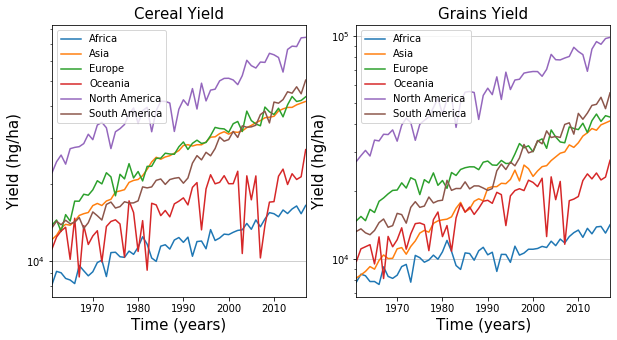

In [14]:
crops = df_prod_crops.copy()
crops.dropna(inplace=True)

cereal_items = [1717, 1814]
crops_cereals = crops[crops['Item Code'].isin(cereal_items)]
print(crops_cereals.Item.unique())

# Compute the log values
crops_cereals['Log Value'] = crops_cereals.Value.transform(lambda x:round(np.log(x)))
crops_cereals['Log Value'] = crops_cereals['Log Value'].replace(-np.inf, 0)

# Take the yield values for cereals
tmp  = crops_cereals[crops_cereals.Element == 'Yield']
cereals_yield = tmp[tmp['Item Code'] == 1717]
cereals_yield = cereals_yield.sort_values('Year')
grains_yield = tmp[tmp['Item Code'] == 1814]
grains_yield = grains_yield.sort_values('Year')

fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(1,2,1)

cereals_yield[cereals_yield.Area == 'Africa'].plot('Year', 'Value', logy=True, ax=ax1)
cereals_yield[cereals_yield.Area == 'Asia'].plot('Year', 'Value', logy=True, ax=ax1)
cereals_yield[cereals_yield.Area == 'Europe'].plot('Year','Value', logy=True, ax=ax1)
cereals_yield[cereals_yield.Area == 'Oceania'].plot('Year', 'Value', logy=True, ax=ax1)
cereals_yield[cereals_yield.Area == 'Northern America'].plot('Year', 'Value', logy=True, ax=ax1)
cereals_yield[cereals_yield.Area == 'South America'].plot('Year', 'Value', logy=True, ax=ax1)
ax1.set_title('Cereal Yield', fontsize=15)
ax1.set_xlabel('Time (years)', fontsize=15)
ax1.set_ylabel('Yield (hg/ha)', fontsize=15)
ax1.legend(['Africa', 'Asia', 'Europe', 'Oceania', 'North America', 'South America'])
ax1.grid(axis='y', alpha=0.75)

ax2 = fig.add_subplot(1,2,2)

grains_yield[grains_yield.Area == 'Africa'].plot('Year', 'Value', logy=True, ax=ax2)
grains_yield[grains_yield.Area == 'Asia'].plot('Year', 'Value', logy=True, ax=ax2)
grains_yield[grains_yield.Area == 'Europe'].plot('Year','Value', logy=True, ax=ax2)
grains_yield[grains_yield.Area == 'Oceania'].plot('Year', 'Value', logy=True, ax=ax2)
grains_yield[grains_yield.Area == 'Northern America'].plot('Year', 'Value', logy=True, ax=ax2)
grains_yield[grains_yield.Area == 'South America'].plot('Year', 'Value', logy=True, ax=ax2)
ax2.set_title('Grains Yield', fontsize=15)
ax2.set_xlabel('Time (years)', fontsize=15)
ax2.set_ylabel('Yield (hg/ha)', fontsize=15)
ax2.legend(['Africa', 'Asia', 'Europe', 'Oceania', 'North America', 'South America'])
ax2.grid(axis='y', alpha=0.75)

Again, the corresponding map follows.

In [32]:
gdf = gpd.read_file("../countries.geo.json")

cereals_yield = replace_values_geojson(cereals_yield)
cereals_yield.drop_duplicates(inplace=True)
cereals_yield.drop(['Area Code', 'Item', 'Item Code', 'Element', 'Element Code', 'Year Code', 'Unit', 'Value', 'Flag'], axis=1, inplace=True)
cereals_yield = cereals_yield.rename(columns={'Area': 'name'})

for y in years:
    j = cereals_yield[cereals_yield.Year == y]
    j.drop('Year', axis=1, inplace=True)
    gdf = gdf.merge(j, on='name', how='left')
    gdf = gdf.rename(columns={'Log Value': 'Cereals %d'%y})
    


In [33]:
# Plot the production on an interactive map
output_file("cereal_yield.html")
     
slider_columns = ["Cereals %d"%i for i in years]

cereal_map = gdf.plot_bokeh(
            figsize = (900,600),
            simplify_shapes=10000,
            colormap_range = [6,12],
            slider = slider_columns,
            slider_range = years,
            slider_name = 'Year',
            colormap = cereal_colormap,
            hovertool_columns = ['id']+slider_columns,
            title='Cereal yields'
            )

save(cereal_map)

'/home/clelie/Bureau/EPFL/ADA/Projet/ada_project-ada_nakamura/to_be_sent/cereal_yield.html'

In 2017, a lot of countries are represented in dark brown, i.e their yields are very high. But how can we quantify this increase? Let's plot the top 10 countries in 1961 and 2017:

In [15]:
tmp = crops_cereals[crops_cereals.Element == 'Yield']
tmp = tmp[tmp['Item Code']==1717]
cereals1961 = tmp[tmp.Year == 1961]
cereals2017 = tmp[tmp.Year == 2017]

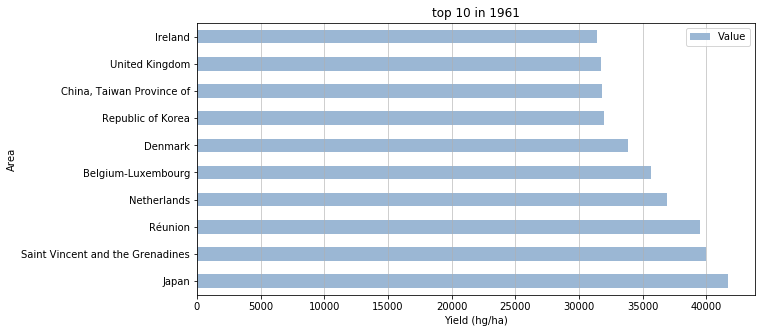

In [16]:
cereals1961 = cereals1961.sort_values(by='Value', ascending=False)[:10]

fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(1,1,1)

cereals1961.plot(kind='barh', x='Area', y='Value', color = '#9bb7d4', ax=ax1)
ax1.set_xlabel('Yield (hg/ha)')
ax1.set_ylabel('Area')
ax1.grid(axis='x', alpha=0.75)
ax1.set_title("top 10 in 1961")
fig.savefig("cereals1961", bbox_inches='tight')

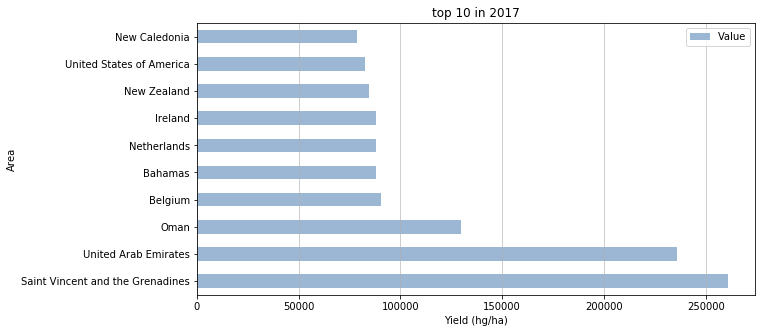

In [40]:
cereals2017 = cereals2017.sort_values(by='Value', ascending=False)[:10]

fig = plt.figure(figsize = (10, 5))
ax2 = fig.add_subplot(1,1,1)

cereals2017.plot(kind='barh', x='Area', y='Value', color = '#9bb7d4', ax=ax2)
ax2.set_xlabel('Yield (hg/ha)')
ax2.set_ylabel('Area')
ax2.grid(axis='x', alpha=0.75)
ax2.set_title("top 10 in 2017")
fig.savefig("cereals2017", bbox_inches='tight')

In [66]:
mean1961 = cereals1961.mean()
mean2017 = cereals2017.mean()
ratio = mean2017.Value/mean1961.Value
print("Mean yield (hg/ha) in top 10 countries in 1961:", mean1961.Value)
print("Mean yield (hg/ha) in top 10 countries in 2017:", mean2017.Value)
print("The mean yield in top 10 countries has been multiplied by %d between 1961 and 2017!"%ratio)

Mean yield (hg/ha) in top 10 countries in 1961: 35464.2
Mean yield (hg/ha) in top 10 countries in 2017: 122692.1
The mean yield in top 10 countries has been multiplied by 3 between 1961 and 2017!


Crops yields have skyrocketted since the 60's, when the Third Agricultural Revolution happened. One good indicator of this revolution is the use of chemicals fertilizers. We will then try to link the use of fertilizers and the yield of countries.

## **Analysis of fertilizer effect on agriculture production**
#### **Handling data**
First let's import the 2 dataset from FAO:
* One about agriculture production containing (among others data) the yield per crops category and per country: Crops from http://www.fao.org/faostat/en/#data/QC
* The other about fertilizer containing quantity used of 3 different fertilizers per area of cropland (from 2002 to 2016): Fertilizers indicators from http://www.fao.org/faostat/en/#data/EF 

In [3]:
#importing needed FAO datasets
fertilizer_area=pd.read_csv('./data/Environment_Fertilizers_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')
crops=pd.read_csv('./data/Production_Crops_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')

#### **1) Fertilizers**
Let's take a look at the fertilizer dataset and the type of data it contains

In [4]:
fertilizer_area.head(3)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2002,2002,kg/ha,3.02,Fc
1,2,Afghanistan,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2003,2003,kg/ha,2.57,Fc
2,2,Afghanistan,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2004,2004,kg/ha,2.96,Fc


In [5]:
# range of year covered by fertilizer dataframe
mini=min(fertilizer_area.Year)
maxi=max(fertilizer_area.Year)
print('Period of time covered by fertilizer_area: %d to %d'%(mini,maxi))

Period of time covered by fertilizer_area: 2002 to 2016


In [6]:
# different types of fertilizers (and associated codes)
ferti_items = pd.DataFrame({'Item':fertilizer_area['Item'].unique(), 'Item Code':fertilizer_area['Item Code'].unique()})
ferti_items

,Item,Item Code
0,Nutrient nitrogen N (total),3102
1,Nutrient phosphate P2O5 (total),3103
2,Nutrient potash K2O (total),3104


In [7]:
# number of countries in the fertilizer dataset
fertilizer_area.Area.unique().size

197

In [8]:
# Checking the presence of missing values
fertilizer_area[fertilizer_area.Value.isnull()]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag


So far, we don't observe any missing value.

However, as we will do an analysis over the years, let's take a look at the pivoted dataframe for the first fertilizer (Nutrient nitrogen N (total)):

In [9]:
ferti_corr=fertilizer_area.query('`Item Code` ==3102')\
                          .pivot(index='Area',columns='Year',values='Value')

print('Verification: number of countries:',ferti_corr.shape[0],', number of years:', ferti_corr.shape[1])
ferti_corr.head()

Verification: number of countries: 197 , number of years: 15


Year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Area,,,,,,,,,,,,,,,
Afghanistan,3.02,2.57,2.96,3.17,6.20,3.57,2.94,4.45,4.19,6.31,27.58,14.45,11.71,11.71,11.71
Africa,11.37,12.49,12.98,12.63,11.34,11.19,12.83,11.21,13.42,12.49,11.99,13.34,14.27,13.37,14.11
Albania,54.34,53.15,51.19,55.94,42.57,44.38,40.39,48.13,48.48,52.74,49.95,44.11,44.13,52.87,60.98
Algeria,3.42,2.07,12.62,0.49,5.23,4.37,2.75,5.69,8.43,7.51,7.89,7.79,12.25,11.83,11.53
Americas,44.75,48.24,47.61,46.88,48.52,52.89,48.92,49.66,53.46,60.11,59.68,59.44,58.48,57.26,60.90


Pivoting the dataframe will create missing values if the fertilizer value of a country is missing for any year. Let's look at it:

In [10]:
# Checking the number of missing values per year
print(ferti_corr.isna().sum())

Year
2002    19
2003    14
2004    10
2005    10
2006    10
2007    10
2008    10
2009     8
2010     8
2011     8
2012     4
2013     3
2014     3
2015     3
2016     4
dtype: int64


From the previous table, we can see that some values are missing for each year (we considered only nitrogen nutrient here). 
We can see that more values are missing for older years and that there are less than 10% of the values (197 countries) which are missing.
Thus, interpolation could be a realistic to fill these missing values.

However, in order to execute a linear interpolation, we need to verify that the evolution is effectively linear:

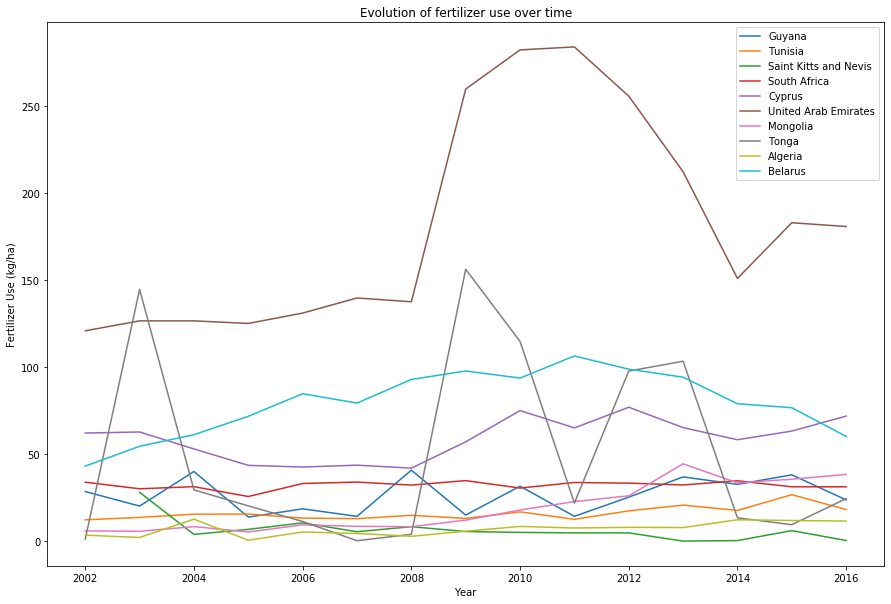

In [11]:
# Visually check the fertilizer evolution over the years
fig = plt.figure(figsize = (15, 10))
for area in fertilizer_area.sample(n=10).Area.unique()[:10]: #take randomly 10 countries in the dataset
    a=fertilizer_area.query('Area == @area and `Item Code`==3102')
    x=a.Year
    y=a.Value
    plt.plot(x,y, label = area)
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Fertilizer Use (kg/ha)')
    plt.title('Evolution of fertilizer use over time')

The previous plot confirm that ferlizers can be interpolated using linear function as the order of magnitude stay the same and that the evolution look quite linear.

Let's perform the interpolation, except for countries with more than half of the years missing. We will drop them instead.

In [12]:
# Create a dataframe containing all the Area Code for each country
area_df=fertilizer_area.loc[:,['Area','Area Code']]
area_df.drop_duplicates(inplace=True)

# Perform the interpolation for each fertilizer:
fertilizer_updated = pd.DataFrame()
for item in ferti_items['Item Code'].values:
    ferti_corr=fertilizer_area.query('`Item Code` ==@item')\
                              .pivot(index='Area',columns='Year',values='Value')
    
    ferti_corr.interpolate(method='linear', axis=1, limit=7, inplace=True, limit_direction='both')
    ferti_corr.dropna(inplace=True)
    ferti_corr.reset_index(inplace=True)
    ferti_corr = pd.melt(ferti_corr, id_vars='Area', value_vars=list(ferti_corr.columns[1:]), 
                         var_name='Year', value_name='Value')
    ferti_corr['Item Code'] = item
    ferti_corr['Item'] = ferti_items.query('`Item Code`== @item').Item.iloc[0]
    ferti_corr['Year Code'] = ferti_corr.Year
    ferti_corr = pd.merge(ferti_corr, area_df, on='Area')
    fertilizer_updated = fertilizer_updated.append(ferti_corr)

fertilizer_updated.reset_index(inplace=True)
fertilizer_updated.drop(columns=['index'],axis=1,inplace=True)
fertilizer_updated.head()

,Area,Year,Value,Item Code,Item,Year Code,Area Code
0,Afghanistan,2002,3.02,3102,Nutrient nitrogen N (total),2002,2
1,Afghanistan,2003,2.57,3102,Nutrient nitrogen N (total),2003,2
2,Afghanistan,2004,2.96,3102,Nutrient nitrogen N (total),2004,2
3,Afghanistan,2005,3.17,3102,Nutrient nitrogen N (total),2005,2
4,Afghanistan,2006,6.20,3102,Nutrient nitrogen N (total),2006,2


In [13]:
# Check for remaining missing values
ferti_corr2=fertilizer_updated.query('`Item Code` ==3102')\
                              .pivot(index='Area',columns='Year',values='Value')

print(ferti_corr2.isnull().sum())

Year
2002    0
2003    0
2004    0
2005    0
2006    0
2007    0
2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
dtype: int64


In [14]:
#Updating the main fertilizer dataset
fertilizer_area = fertilizer_updated
fertilizer_area.head()

,Area,Year,Value,Item Code,Item,Year Code,Area Code
0,Afghanistan,2002,3.02,3102,Nutrient nitrogen N (total),2002,2
1,Afghanistan,2003,2.57,3102,Nutrient nitrogen N (total),2003,2
2,Afghanistan,2004,2.96,3102,Nutrient nitrogen N (total),2004,2
3,Afghanistan,2005,3.17,3102,Nutrient nitrogen N (total),2005,2
4,Afghanistan,2006,6.20,3102,Nutrient nitrogen N (total),2006,2


#### **2) Crop dataset**
We decided to use grouped yields to reduce risks of collinearity in the dataset (grouped crops are more likely to regroup all dependent features together).

First, let's take a look at the yields for each country in 2004 (arbitrarily selected):

In [15]:
#extract of yield in the crop dataset and pivot to obtain a dataframe with yields as columns (features) and countries as rows
crop_corr=(crops.query('`Element Code` == 5419') #The element code of yield is 5419
                .query('`Year Code` == 2004')
                .query('`Item Code` >1000') #grouped yields correspond to item codes > 1000
                .pivot(index='Area',columns='Item',values='Value')
                .reset_index())

print('There are', crop_corr.shape[0], 'countries and', crop_corr.shape[1]-1,'yields in the dataset.')
crop_corr.head()

There are 244 countries and 12 yields in the dataset.


Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,Afghanistan,12770.0,13348.0,78025.0,12106.0,3624.0,79157.0,3981.0,2725.0,10769.0,176471.0,12909.0,132255.0
1,Africa,13324.0,13988.0,90024.0,11963.0,3563.0,74572.0,3113.0,2716.0,5676.0,87147.0,6764.0,92421.0
2,Albania,34663.0,34663.0,74994.0,39264.0,2972.0,150953.0,3969.0,3713.0,10197.0,149346.0,46290.0,189790.0
3,Algeria,13440.0,13441.0,138702.0,13155.0,1426.0,50839.0,9834.0,4699.0,8049.0,203585.0,12473.0,131958.0
4,American Samoa,NaN,NaN,NaN,NaN,NaN,36975.0,1709.0,2777.0,NaN,35805.0,NaN,42432.0


We can see that there are some missing value (either due to missing values in the crops dataset or to unproduced crops by a country).
How many are there?

In [16]:
# Count massing values per crops category in 2004
print(crop_corr.isna().sum()[crop_corr.isna().sum()!=0])

Item
Cereals (Rice Milled Eqv)     27
Cereals,Total                 27
Citrus Fruit,Total            72
Coarse Grain, Total           31
Fibre Crops Primary           90
Fruit Primary                  6
Oilcrops, Cake Equivalent     18
Oilcrops, Oil Equivalent      16
Pulses,Total                  39
Roots and Tubers,Total         7
Treenuts,Total               100
Vegetables Primary             6
dtype: int64


We can expand that analysis for all years:

In [17]:
# count total number of missing values for all years
year_range=range(2002,2016+1)
miss_count=pd.DataFrame()
for year in year_range:    
    crop_year = (crops.query('`Element Code` == 5419') #select the yields
                      .query('`Year Code` == @year') #select the year
                      .query('`Item Code` >1000') #select the group yields
                      .query('`Area Code` <300') #deselect the group of countries (such as Africa, America, ...)
                      .pivot(index='Area Code',columns='Item',values='Value')
                      .reset_index())
    
    keys = ['Total number of rows'] + crop_year.columns.values.tolist()[1:]
    values = [crop_year.shape[0]] + crop_year.isna().sum().values.tolist()[1:] #count the missing values
    dictionary = dict(zip(keys, values))
    df = pd.DataFrame.from_records([dictionary])
    miss_count = miss_count.append(df,sort=False)
    
print(miss_count.sum())
print('There are',miss_count.sum()[1:].sum(), 'missing values in total')

Total number of rows         3149.0
Cereals (Rice Milled Eqv)     389.0
Cereals,Total                 389.0
Citrus Fruit,Total           1063.0
Coarse Grain, Total           448.0
Fibre Crops Primary          1154.0
Fruit Primary                  88.0
Oilcrops, Cake Equivalent     229.0
Oilcrops, Oil Equivalent      194.0
Pulses,Total                  554.0
Roots and Tubers,Total        103.0
Treenuts,Total               1486.0
Vegetables Primary             88.0
dtype: float64
There are 6185.0 missing values in total


Treenuts, Fibre Crops Primary and Citrus Fruit,Total presents 3703 missing values, 60% of the total number of missing values.

#### **Interpolating to replace missing values**
Interpolation contains 4 steps:

- Creating 2 datasets: the first one will contain rows with missing values. In the second one, missing values will be dropped. This dataset will be the recipient of the interpolated values.
- Interpolate missing values from the second dataset (except when there are too much missing values as in the fertilizer interpolation)
- Add these missing values in the initial crops dataset
- Check for remaining missing values

1) creating the 2 datasets

In [18]:
area_indexed=crops.query('`Element Code` == 5419 and `Item Code` >1000 and `Area Code`<300').set_index(['Area Code', 'Item'])
area_indexed.head()

Area  Item Code  Element Code  \
Area Code Item                                                              
2         Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   

                                    Element  Year Code  Year   Unit    Value  \
Area Code Item                                                                 
2         Cereals (Rice Milled Eqv)   Yield       1961  1961  hg/ha  10831.0   
          Cereals (Rice Milled Eqv)   Yield       1962  1962  hg/ha  10480.0   
          Cereals (Rice Milled Eqv)   Yield       1963  1963  hg/ha   9548.0   
          Cereals (Rice Milled Eqv)   Yield       1964  1964  hg/ha  10461.0   
          Cereals (Rice Milled Eqv)   Yield       1965  1965  hg/ha  10621.0   

                                    Flag  
Area Code Item                            
2         Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc

In [19]:
year_range=pd.Series(range(2002,2016+1))
missing_values=pd.DataFrame(columns=['Area Code','Item','Year'])
for area in area_indexed.index.get_level_values(level=0).unique().values:
    for item in area_indexed.loc[area].index.unique().values:
        year_missing=year_range[~year_range.isin(area_indexed.loc[area].loc[item].query('Year>=2002 and Year <=2016').Year)]
        for year in year_missing:
            missing_values =missing_values.append({'Area Code':area,'Item':item,'Year':year},ignore_index=True)
missing_values.head()
        

,Area Code,Item,Year
0,2,Fibre Crops Primary,2015
1,2,Fibre Crops Primary,2016
2,2,"Oilcrops, Cake Equivalent",2015
3,2,"Oilcrops, Cake Equivalent",2016
4,2,"Oilcrops, Oil Equivalent",2015


In [20]:
print('There are',missing_values.shape[0],'rows with missing values')

There are 2807 rows with missing values


In [21]:
# Creating the 2nd dataset
dropnan_crops=crops.dropna(axis=0, subset=['Value']).query('Year >= 2002 and `Element Code`==5419 and `Item Code` >1000')

2) Executing the interpolation:

In [22]:
'''count=0
#Purpose of this code : adding missing value by interpolation 
for x in missing_values['Area Code'].unique():
    for j in missing_values.query('`Area Code` == @x').Item.unique():
        if dropnan_crops.query('`Area Code` == @x').query('`Item` == @j').shape[0]>=5 : # That condition is set to avoid replacing value for countries with not enough values
            interpolation_coef = np.polyfit(dropnan_crops.query('`Area Code` == @x').query('Item == @j').Year,
                                            dropnan_crops.query('`Area Code` == @x').query('Item == @j').Value,
                                            1)
            poly = np.poly1d(interpolation_coef)
            for year in missing_values.query('`Area Code` == @x').query('`Item` == @j').Year.values:
                interp_value = poly(year)
                template = (dropnan_crops.query('`Area Code` == @x')
                                        .query('`Item` == @j').head(1))
                to_add = template.values
                to_add[0][9] = interp_value
                to_add[0][6] = year
                to_add[0][7] = year
                to_add=pd.DataFrame(to_add, columns=template.columns.values)
                crops=crops.append(to_add, ignore_index=True, sort=False)
                count+=1
                #t=t.append(to_add,ignore_index=True)
print("The operation replaced %d values"%count)
'''

'count=0\n#Purpose of this code : adding missing value by interpolation \nfor x in missing_values[\'Area Code\'].unique():\n    for j in missing_values.query(\'`Area Code` == @x\').Item.unique():\n        if dropnan_crops.query(\'`Area Code` == @x\').query(\'`Item` == @j\').shape[0]>=5 : # That condition is set to avoid replacing value for countries with not enough values\n            interpolation_coef = np.polyfit(dropnan_crops.query(\'`Area Code` == @x\').query(\'Item == @j\').Year,\n                                            dropnan_crops.query(\'`Area Code` == @x\').query(\'Item == @j\').Value,\n                                            1)\n            poly = np.poly1d(interpolation_coef)\n            for year in missing_values.query(\'`Area Code` == @x\').query(\'`Item` == @j\').Year.values:\n                interp_value = poly(year)\n                template = (dropnan_crops.query(\'`Area Code` == @x\')\n                                        .query(\'`Item` == @j\').head(1)

Optional: Saving modified crops to avoid re-running the interpolation

In [23]:
#crops.to_pickle("crops_interpolated") # uncomment to save again into pickle

In [24]:
crops=pd.read_pickle("crops_interpolated")

In [25]:
# Reset index to avoid index issues
crops=crops.reset_index()
crops.drop(columns=['index'],axis=1, inplace=True)
crops.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0,F


3) Checking changed values 

In [26]:
# count number of replaced values
area_indexed2=crops.query('`Element Code` == 5419 and `Item Code` >1000 and `Area Code`<300').set_index(['Area Code', 'Item'])
area_indexed2.shape[0]-area_indexed.shape[0]

1371

Let's take a look at how many missing values have been replaced :

In [27]:
year_range=pd.Series(range(2002,2016+1))
missing_values2=pd.DataFrame(columns=['Area Code','Item','Year'])
for area in area_indexed2.index.get_level_values(level=0).unique().values:
    for item in area_indexed2.loc[area].index.unique().values:
        year_missing=year_range[~year_range.isin(area_indexed2.loc[area].loc[item].query('Year>=2002 and Year <=2016').Year)]
        for year in year_missing:
            missing_values2 =missing_values2.append({'Area Code':area,'Item':item,'Year':year},ignore_index=True)
miss_count2=pd.DataFrame()
for year in fertilizer_area.Year.unique():    
    crop_year=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
        .query('`Year Code` == @year')
        .query('`Item Code` >1000')
        .query('`Area Code` <300')
        .pivot(index='Area',columns='Item',values='Value')
        .reset_index()
          )
    keys=['Total number of rows']+crop_year.columns.values.tolist()[1:]
    values=[crop_year.shape[0]]+np.round(crop_year.isnull().sum().values).tolist()[1:]
    dictionary = dict(zip(keys, values))
    df=pd.DataFrame.from_records([dictionary])
    miss_count2=miss_count2.append(df, sort=False)
print(miss_count2.sum())
print('There are',miss_count2.sum()[1:].sum(), 'missing values in total')

Total number of rows         3184
Cereals (Rice Milled Eqv)     390
Cereals,Total                 390
Citrus Fruit,Total           1065
Coarse Grain, Total           450
Fibre Crops Primary          1346
Fruit Primary                  90
Oilcrops, Cake Equivalent     279
Oilcrops, Oil Equivalent      234
Pulses,Total                  555
Roots and Tubers,Total        105
Treenuts,Total               1500
Vegetables Primary             90
dtype: int64
There are 6494 missing values in total


In [28]:
print(miss_count.sum())
print('There are',miss_count.sum()[1:].sum(), 'missing values in total')

Total number of rows         3149.0
Cereals (Rice Milled Eqv)     389.0
Cereals,Total                 389.0
Citrus Fruit,Total           1063.0
Coarse Grain, Total           448.0
Fibre Crops Primary          1154.0
Fruit Primary                  88.0
Oilcrops, Cake Equivalent     229.0
Oilcrops, Oil Equivalent      194.0
Pulses,Total                  554.0
Roots and Tubers,Total        103.0
Treenuts,Total               1486.0
Vegetables Primary             88.0
dtype: float64
There are 6185.0 missing values in total


Our first dataset (before the interpolation) has less missing values than the second one. Some rows have been added to the second one, explaining thus the difference.

Let's take a look at number of missing values by column and year for both cases:

In [29]:
miss_count2-miss_count

,Total number of rows,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,4,0,0,-1,0,2.0,0,1.0,0.0,-1,0,-1,0
0,4,0,0,-1,0,3.0,0,1.0,0.0,0,0,-1,0
0,4,0,0,1,0,3.0,0,1.0,0.0,0,0,1,0
0,4,0,0,1,0,3.0,0,1.0,0.0,0,0,1,0
0,2,-1,-1,0,0,0.0,0,1.0,1.0,0,0,1,0
0,2,0,0,0,0,1.0,0,1.0,1.0,0,0,1,0
0,2,0,0,0,0,0.0,0,1.0,1.0,0,0,2,0
0,2,0,0,0,0,1.0,0,1.0,1.0,0,0,2,0
0,2,0,0,0,0,1.0,0,2.0,2.0,0,0,2,0
0,2,0,0,0,0,1.0,0,2.0,2.0,0,0,2,0


One can notice from the table that there were 3 columns with NaN value. This is due to complete absence of data for these crops for 2015 and 2016. 

Hence, the interpolation program extrapolated for these two years and thus replaced NaN values by missing values in the previous tables. This explains the extra missing values in the last dataset.

Moreover, the extrapolation replaced missing features for the two last years allowing us to carry out machine learning on all years (as we have all features for each years) and to compare results within years. 

Finally, as we have a big proportion of the countries with missing values for "Treenuts", "Fibre Crops Primary" and "Citrus Fruit,Total", we will drop these features during the next part.

#### **Correlation between crops production**

For an efficient use of machine learning algorithms, it is better to work with independant features. Therefore, let's take a look at the correlation heatmap between features:

Text(0.5, 1, 'Correlation matrix for the yields')

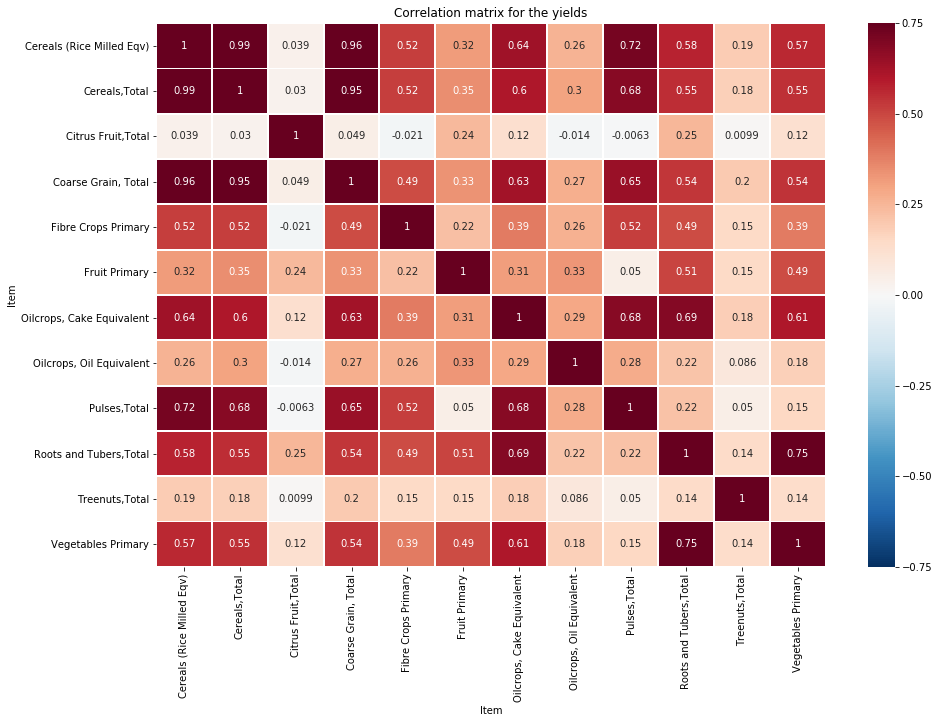

In [30]:
# correlation for the year 2004
correlation = crop_corr.corr()

# Plotting correlation map
plt.figure(figsize=(15,10))
heatmap = sns.heatmap(correlation, annot=True, linewidths=1, center=0,\
                      vmin=-0.75, vmax=0.75, cmap="RdBu_r")
plt.title("Correlation matrix for the yields")

We can see that cereals are strongly correlated. Thus, we will merge them.

#### **Dimensionality reduction**

We don’t have the amount of fertilizer by category of crops, but only the value of the global use of fertilizers is provided. Thus,to properly compare yields and fertilizers, we need to construct a global value representing as well as possible all the complete agriculture of a country, i.e. reduce all the yields of a country to one indicator.

To do so, we preferred to use dimensionality reduction methods rather than a simple sum because of their better ability to maintain the distance information between objects (here, countries).

2 different algorithms for dimensionality reduction will be used:
* Umap because it can capture non-linear relations
* PCA because it gives us information about the importance of each feature through coefficients


#### **Umap reduction**

In [31]:
# This function separates countries into three different groups according to their fertilizer use
def ferti_class(x, L): 
    ''' x is the fertilizer value, L is the set of fertilizer values'''
    if x<np.percentile(L,33):
        return 'low'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'medium'
    else:
        return 'high'

Definition ot the function calculating the umap reduction:

Inputs: year, 1 fertilizer code and number of final dimension(s).

Outputs: computed year, a dataframe with Umap score as well as fertilizer value for each country and coefficient from a linear interpolation of the result (fertilizer value vs umap score)


In [32]:

def umap_year(year, ferti_code, n_components=2): 
    yield_for_merge=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .query('`Area Code` <300') # Exclusion of grouped areas
            .pivot(index='Area',columns='Item',values='Value')
            .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])# drop columns with to many missing values
            .reset_index()
            
              )
    yield_for_merge['Cereal']=yield_for_merge.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    yield_for_merge.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    yield_for_merge=yield_for_merge.dropna(axis=0)
    yield_for_umap=yield_for_merge.drop('Area',axis=1).values 
    
    #Normalization 
    x = yield_for_umap
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    yield_for_umap = pd.DataFrame(x_scaled)
    
    reducer = umap.UMAP(random_state=1, n_components= n_components)
    embedding = reducer.fit_transform(yield_for_umap)
    embedding2=pd.DataFrame(embedding)
    embedding2=pd.merge(embedding2,yield_for_merge['Area'], left_index=True, right_index=True)
    
    #importation of fertilizer dataset
    umap_fertilizer=(fertilizer_area
                    .query('Year == @year')
                    .query('`Area Code` <300')
                    .query('`Item Code` == @ferti_code')
                    .query('Value > 0')
                    )
    embedding2=pd.merge(embedding2,umap_fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')
    
    #Result normalization to be able to compare them between years
    embedding2[0]=(embedding2[0]-min(embedding2[0]))/(max(embedding2[0])-min(embedding2[0]))
    embedding2.rename(columns={0: "Umap"}, inplace=True)
    embedding2['Value']=(embedding2['Value']-min(embedding2['Value']))/(max(embedding2['Value'])-min(embedding2['Value']))
    embedding2['ferti_class']=embedding2.Value.apply(lambda x: ferti_class(x, embedding2.Value))
    
    coef = np.polyfit(embedding2['Umap'],embedding2.Value,1)
    
    return year,embedding2,coef # return year (for confirmation), performed umap and value of linear regression

Now that the function is defined, let's take a look at the relationship between fertilizer use and umap projection over the year. The linear interpolation is also plotted.

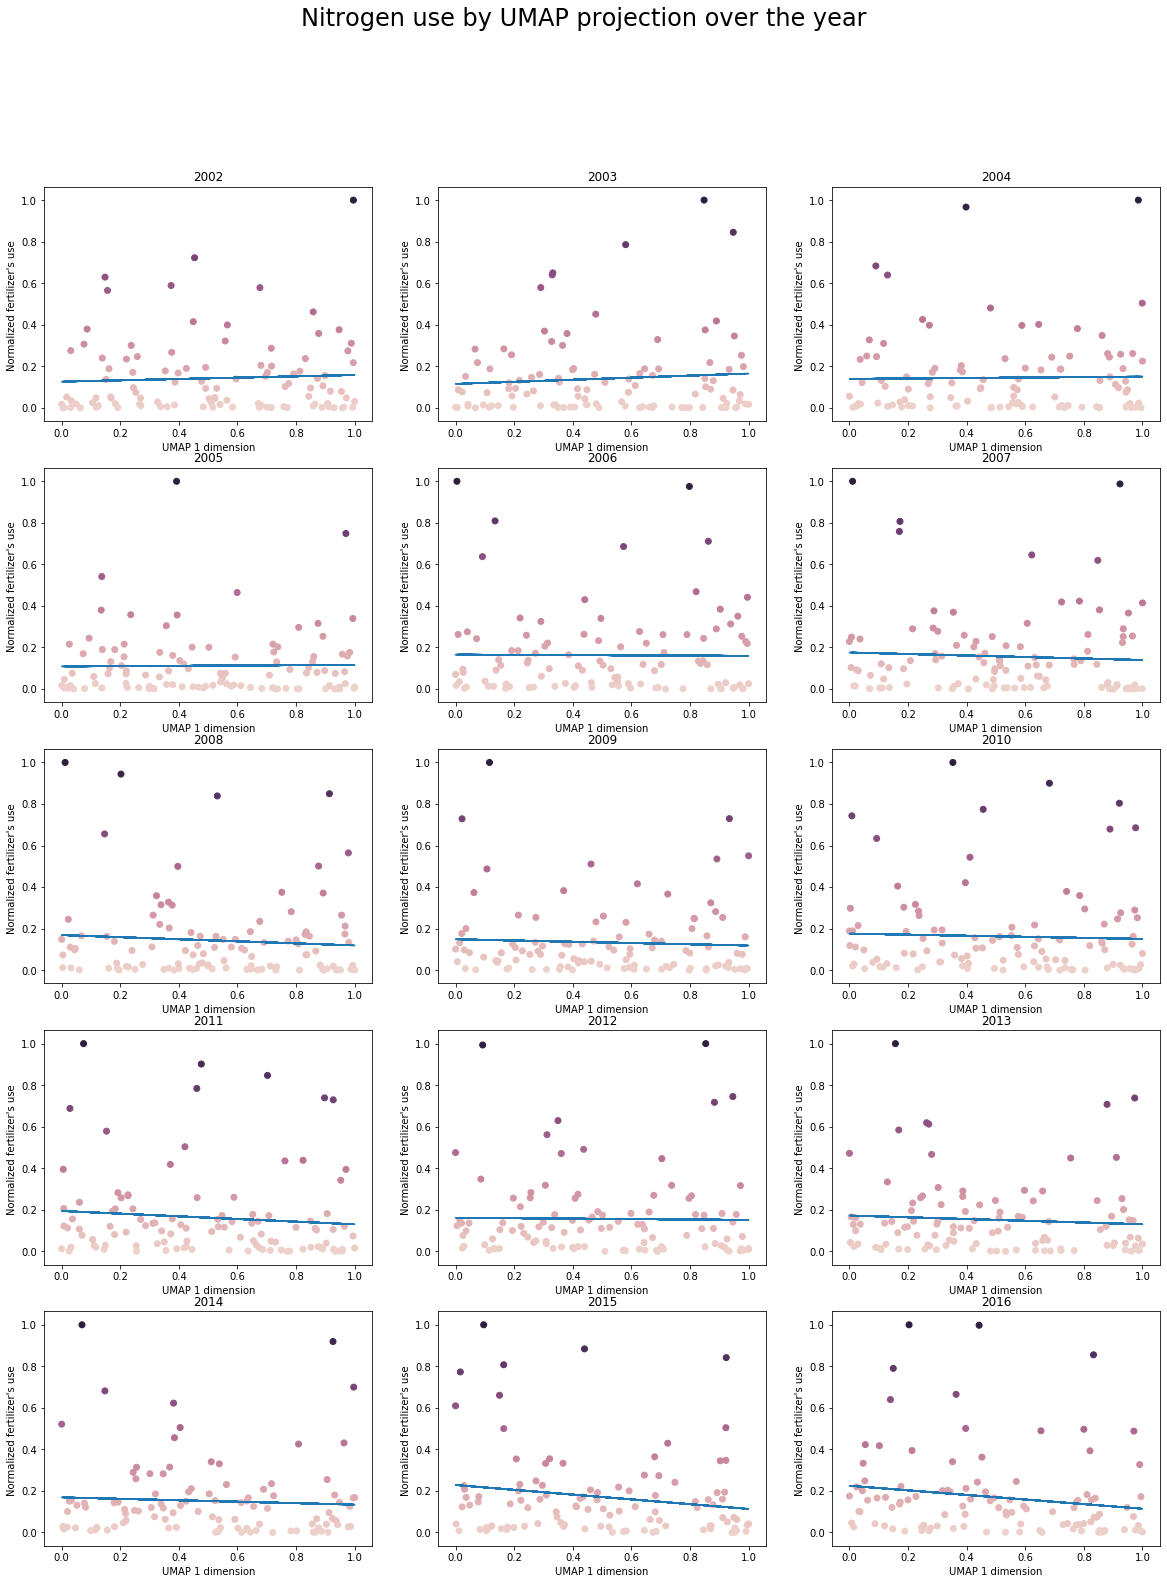

In [33]:
#plot for multiple years for Nutrient nitrogen N vs umap
year=fertilizer_area['Year Code'].unique()
n=len(year)
fig = plt.figure(figsize = (20, math.ceil(n/3)*5 ))
fig.suptitle('Nitrogen use by UMAP projection over the year', fontsize=24)
for x in range (n) : 
    vis_2016=umap_year(year[x], 3103, 1)
    ax1 = fig.add_subplot(math.ceil(n/3),3,x+1)
    embedding2=vis_2016[1] 
    coef = vis_2016[2]
    poly1d_fn = np.poly1d(coef)
    clarity_ranking = embedding2.Value
    cmap = sns.cubehelix_palette(as_cmap=True)
    plt.scatter(embedding2['Umap'], embedding2.Value,c=clarity_ranking, cmap=cmap)
    plt.plot(embedding2['Umap'], poly1d_fn(embedding2['Umap']))
    plt.title('%d'%year[x]);
    plt.xlabel("UMAP 1 dimension")
    plt.ylabel("Normalized fertilizer's use ")

The correlation between Umap and fertilizer use is weak. We will therefore not explore this tool anymore.

## **PCA**

First let's create some necessary functions :


In [34]:
#preparing the dataset for pca
def pre_processing_PCA(df, target, features):
    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the countries
    y = df.loc[:,[target]].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    return x

# Applying the pca, return the pca as well as the score for each target
def PCA_processing(df, target, features):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(pre_processing_PCA(df, target, features))
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
    return pca,pd.concat([principalDf, df[[target]]], axis=1)

#### **Distinguish countries on their fertilizer use :**
The function below separates countries into three differents equally sized groups according to their fertilizer use.
We choose to do so because as we are not agronomist, it would be very subjective to set range for each group. And as we 

In [35]:
# This function separates countries into three different groups according to their fertilizer use
def ferti_class(x, L): 
    ''' x is the fertilizer value, L is the set of fertilizer values'''
    if x<np.percentile(L,33):
        return 'low'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'medium'
    else:
        return 'high'

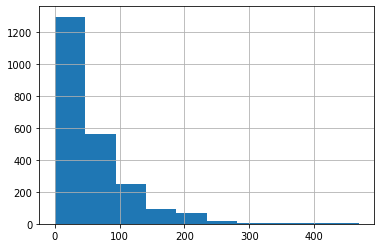

In [36]:
# looking at the fertilizer distribution 
fertilizer=(fertilizer_area.query('`Item Code` == (3102)')
    .query('`Area Code` <300') #exclude the grouped countried (i.e. europe, etc)
    .sort_values('Value', ascending=False)
    .dropna()
)
fertilizer.Value.hist()

In order to be able to make an analysis over the years, we need to look at the evolution of our three groups of fertilizer over the years to see if it stays relatively the same :

In [37]:
# Creating a dataset with fertilizer value and fertilizer group for each year and each country
ferti_box=pd.DataFrame(columns=['Area'])
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    ferti=(fertilizer_area
            .query('`Year Code` == @year')
            .query('`Item Code` ==3102')
            .query('`Area Code` <300')
            .pivot(index='Area',columns='Item Code',values='Value')
            .dropna(axis=0)
            .reset_index()
              )
    ferti.rename(columns={3102:str(year)},inplace=True)
    ferti['ferti_class'+str(year)]=ferti[str(year)].apply(lambda x: ferti_class(x, ferti[str(year)]))
    ferti.dropna(axis=0, inplace=True)
    ferti_box=ferti.merge(ferti_box,on='Area',how='outer')
    
ferti_box.head(2)

,Area,2016,ferti_class2016,2015,ferti_class2015,2014,ferti_class2014,2013,ferti_class2013,2012,...,2006,ferti_class2006,2005,ferti_class2005,2004,ferti_class2004,2003,ferti_class2003,2002,ferti_class2002
0,Afghanistan,11.71,low,11.71,low,11.71,low,14.45,low,27.58,...,6.20,low,3.17,low,2.96,low,2.57,low,3.02,low
1,Albania,60.98,medium,52.87,medium,44.13,medium,44.11,medium,49.95,...,42.57,medium,55.94,high,51.19,medium,53.15,medium,54.34,high


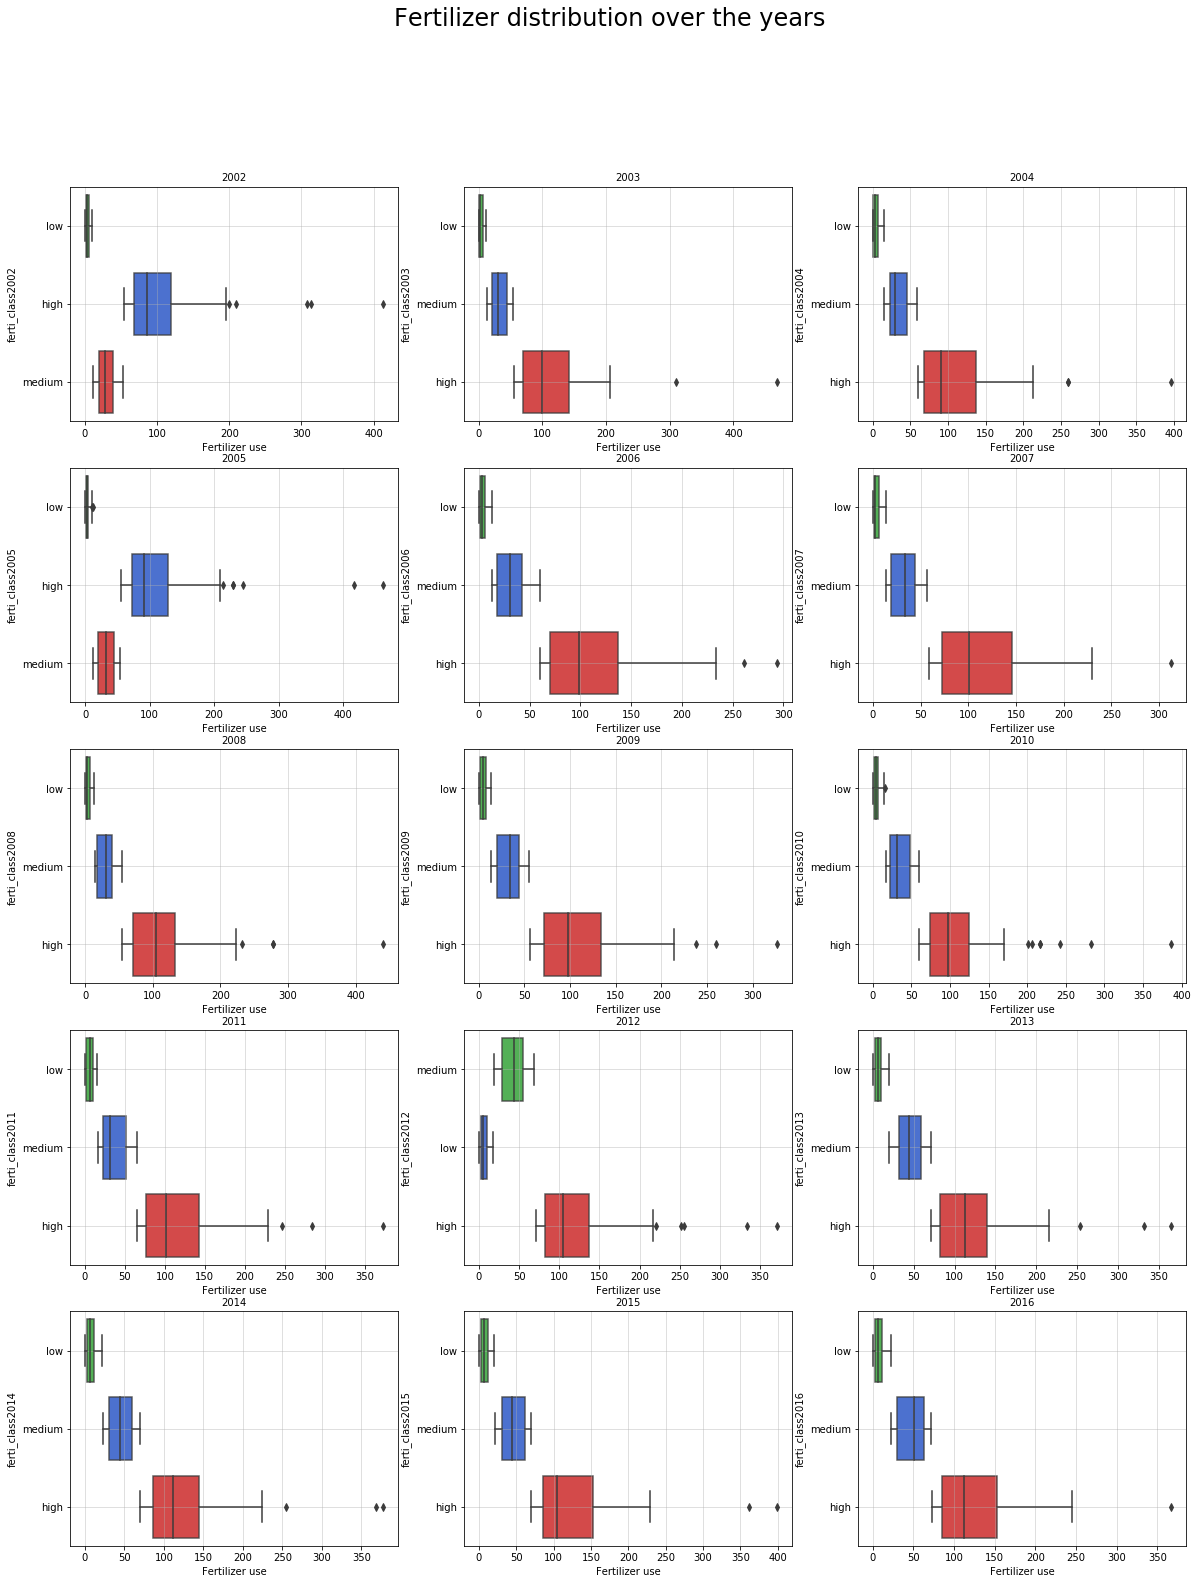

In [38]:
# Plot the distribution :
colors = ["green", "blue", "red"]
year=fertilizer_area['Year Code'].unique()
n=len(year)
fig = plt.figure(figsize = (20, math.ceil(n/3)*5 ))
fig.suptitle('Fertilizer distribution over the years', fontsize=24)
for x in range (n) : 
    ax1 = fig.add_subplot(math.ceil(n/3),3,x+1)
    ax1 = sns.boxplot(x=str(x+2002), y='ferti_class'+str(x+2002), data=ferti_box, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
    ax1.grid(alpha=0.5)
    plt.xlabel('Fertilizer use')
    plt.title(str(x+2002), fontsize=10);

We can see that expect for year 2002, 2005 and 2012, the distribution stay similar. Thus it's correct to use median of the tree groups over the year for our analysis.

#### **PCA Analysis for 1 year**
Now we can take a look at the PCA repartition by fertilizer group for the most recent year :

In [39]:
#Creating 2 datasets for 2016: one containing fertilizer value, another containing the yields
fertilizer=(fertilizer_area.query('`Item Code` == (3102)')
    .query('`Year Code` == 2016')
    .query('`Area Code` <300') #exclude the grouped countried (i.e. europe, etc)
    .dropna(axis=0)
)
grouped_yields=(crops.query('`Element Code` == 5419') #take yield 
        .query('`Year Code` == 2016')
        .query('`Item Code` >1000') #take the grouped crops
        .query('`Area Code` <300')
        .pivot(index='Area',columns='Item',values='Value')
        .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])# drop columns with to many missing values
        .reset_index()
          )
grouped_yields['Cereal']=grouped_yields.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
grouped_yields=grouped_yields.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
grouped_yields.dropna(axis=0, inplace=True)
grouped_yields=grouped_yields.reset_index()
grouped_yields.drop(columns=['index'],inplace=True)

In [40]:
# Applying the PCA and merging with fertilizer values
pca,grouped_yield_pca = PCA_processing(grouped_yields,'Area', grouped_yields.columns[1:])
grouped_yield_pca=pd.merge(grouped_yield_pca,fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')
grouped_yield_pca['ferti_class']=grouped_yield_pca.Value.apply(lambda x: ferti_class(x, grouped_yield_pca.Value))
grouped_yield_pca.dropna(axis=0, inplace=True)

Text(0, 0.5, 'Fertilizer use')

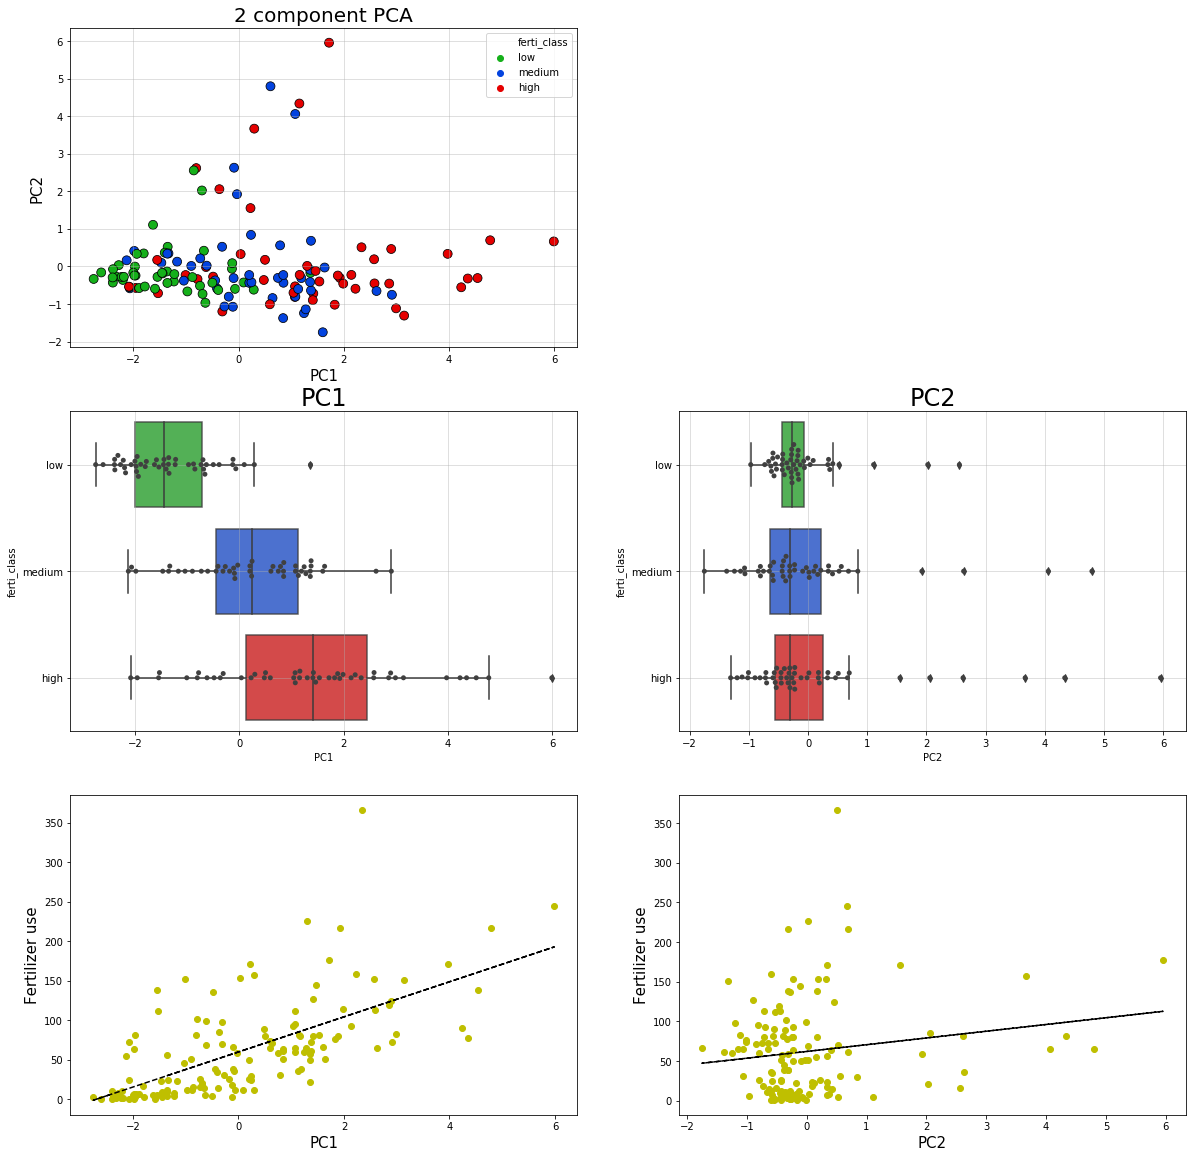

In [41]:
#Visualization 
figure = plt.figure(figsize = (20,20))
colors = ["green", "blue", "red"]

ax1 = figure.add_subplot(3,2,1)
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('2 component PCA', fontsize = 20)
ax1.grid(alpha=0.5)
ax1 = sns.scatterplot(x='PC1', y='PC2', hue='ferti_class', palette=sns.xkcd_palette(colors), data=grouped_yield_pca, s=80,edgecolor="black")

ax2 = figure.add_subplot(3,2,3)
ax2 = sns.boxplot(x='PC1', y='ferti_class', data=grouped_yield_pca, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax2 = sns.swarmplot(x='PC1', y='ferti_class', data=grouped_yield_pca, color=".25")
ax2.grid(alpha=0.5)
plt.title('PC1', fontsize=24);

ax3 = figure.add_subplot(3,2,4)
ax3 = sns.boxplot(x='PC2', y='ferti_class', data=grouped_yield_pca, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax3 = sns.swarmplot(x='PC2', y='ferti_class', data=grouped_yield_pca, color=".25")
ax3.grid(alpha=0.5)
plt.title('PC2', fontsize=24);

ax4 = figure.add_subplot(3,2,5)
coef = np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.Value,1)
poly1d_fn = np.poly1d(coef)
plt.plot(grouped_yield_pca.PC1,grouped_yield_pca.Value, 'yo',grouped_yield_pca.PC1, poly1d_fn(grouped_yield_pca.PC1), '--k')
ax4.set_xlabel('PC1', fontsize = 15)
ax4.set_ylabel('Fertilizer use', fontsize = 15)

ax5 = figure.add_subplot(3,2,6)
coef = np.polyfit(grouped_yield_pca.PC2,grouped_yield_pca.Value,1)
poly1d_fn = np.poly1d(coef)
plt.plot(grouped_yield_pca.PC2,grouped_yield_pca.Value, 'yo',grouped_yield_pca.PC2, poly1d_fn(grouped_yield_pca.PC2), '--k')
ax5.set_xlabel('PC2', fontsize = 15)
ax5.set_ylabel('Fertilizer use', fontsize = 15)

**Comment last graph**
We should say that we keep pc1, we should see different groups 



In [42]:
# Instead of attributin value to each group, this function attributes colors
def ferti_color(x, L): 
    ''' x is the fertilizer value, L is the set of fertilizers values'''
    if x<np.percentile(L,33):
        return 'green'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'orange'
    else:
        return 'red'

In [43]:
#Creating a dataframe containing for each country : the PC1, the fertilizer use and color group over the year
pca_ferti_frame=pd.DataFrame(columns=['Area'])
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    grouped_yield=(crops.query('`Element Code` == 5419')
    .query('`Year Code` == @year')
    .query('`Item Code` >1000')
    .query('`Area Code` <300')
    .pivot(index='Area',columns='Item',values='Value')
    .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])
    .reset_index()
    )

    grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    grouped_yield=grouped_yield.dropna(axis=0)
    grouped_yield=grouped_yield.reset_index()
    grouped_yield.drop(columns=['index'],inplace=True)
    
    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])
    grouped_yield_pca.rename(columns={'PC1':str(year)},inplace=True)
    pca_ferti_frame=pca_ferti_frame.merge(grouped_yield_pca.loc[:,['Area',str(year)]], on='Area',how='outer')
    
    ferti=(fertilizer_area
        .query('`Year Code` == @year')
        .query('`Item Code` ==3102')
        .query('`Area Code` <300')
        .pivot(index='Area',columns='Item Code',values='Value')
        .dropna(axis=0)
        .reset_index()
          )
    ferti.rename(columns={3102:str(year)+'_ferti'},inplace=True)
    ferti.dropna(axis=0, inplace=True)
    ferti['ferti_color_'+str(year)]=ferti[str(year)+'_ferti'].apply(lambda x: ferti_color(x, ferti[str(year)+'_ferti']))
    pca_ferti_frame=pca_ferti_frame.merge(ferti.loc[:,['Area',str(year)+'_ferti','ferti_color_'+str(year)]], on='Area',how='left')
pca_ferti_frame.head(5)

,Area,2002,2002_ferti,ferti_color_2002,2003,2003_ferti,ferti_color_2003,2004,2004_ferti,ferti_color_2004,...,ferti_color_2013,2014,2014_ferti,ferti_color_2014,2015,2015_ferti,ferti_color_2015,2016,2016_ferti,ferti_color_2016
0,Afghanistan,-0.814322,3.02,green,-0.815293,2.57,green,-0.905765,2.96,green,...,green,-1.149030,11.71,green,-1.260170,11.71,green,-1.359291,11.71,green
1,Albania,0.462978,54.34,red,0.168131,53.15,orange,0.062443,51.19,orange,...,orange,1.250716,44.13,orange,1.277543,52.87,orange,1.374337,60.98,orange
2,Algeria,-0.778872,3.42,green,-0.376293,2.07,green,-0.516225,12.62,green,...,green,0.202174,12.25,green,0.281118,11.83,green,0.287093,11.53,green
3,Angola,-1.741561,0.81,green,-1.747918,0.50,green,-1.918447,2.00,green,...,green,-1.543238,5.32,green,-1.591230,4.91,green,-1.626394,4.89,green
4,Argentina,1.903843,18.52,orange,2.196640,24.95,orange,1.604389,25.06,orange,...,green,1.449124,19.67,green,1.527095,14.52,green,1.363239,22.53,orange


In [44]:
# Create dataframe containing coordinates of 2 points resulting from linear interpolation of "fertilizer vs pc1 score"  over the years
interpo_data=pd.DataFrame(index=[1,2])
yield_interp=pca_ferti_frame.dropna(axis=0)
for year in range(2002,2016+1,1):
    par = np.polyfit(yield_interp[str(year)], yield_interp[str(year)+'_ferti'], 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    x=[min(yield_interp[str(year)]), max(yield_interp[str(year)])]
    y_predicted = [slope*min(yield_interp[str(year)]) + intercept, slope*max(yield_interp[str(year)]) + intercept]
    interpo_data['x_'+str(year)] = x
    interpo_data['y_'+str(year)] = y_predicted
interpo_data

,x_2002,y_2002,x_2003,y_2003,x_2004,y_2004,x_2005,y_2005,x_2006,y_2006,...,x_2012,y_2012,x_2013,y_2013,x_2014,y_2014,x_2015,y_2015,x_2016,y_2016
1,-3.388731,-29.461652,-2.670364,-14.365059,-2.727179,-6.709779,-2.730583,-10.465113,-2.648260,-8.044797,...,-2.598181,0.882828,-2.647327,1.124593,-2.649745,1.063387,-2.724674,-1.037223,-2.754072,-1.226322
2,6.381528,198.143196,6.222031,208.029530,6.713823,197.716000,6.541774,194.218018,6.187189,184.988274,...,6.028353,182.239521,6.116709,184.587173,6.075917,185.455168,6.077624,192.120573,5.988065,192.973586


In [45]:
from bokeh.layouts import column, row
from bokeh.models import CustomJS, ColumnDataSource, Slider, tickers
from bokeh.plotting import Figure, show
from bokeh.models.tickers import ContinuousTicker,FixedTicker,SingleIntervalTicker

# fetch and clear the document
from bokeh.io import curdoc
curdoc().clear()


source = ColumnDataSource(pca_ferti_frame)

yield_interp=pca_ferti_frame.dropna(axis=0)
par = np.polyfit(yield_interp['2002'], yield_interp['2002_ferti'], 1, full=True)
slope=par[0][0]
intercept=par[0][1]
y_predicted = [slope*min(yield_interp['2002']) + intercept, slope*max(yield_interp['2002']) + intercept]

TOOLTIPS = [
    ("Area", "@Area"),
    ("fertilizer use ","@2002_ferti"),
    ("Indicator score","@2002")
]

interpo = ColumnDataSource(interpo_data)

plot = Figure(plot_width=400, plot_height=400, tooltips=TOOLTIPS)
plot.circle(x='2002', y='2002_ferti', source=source, size=6, color="ferti_color_2002", alpha=0.5)
plot.line(x='x_2002',y='y_2002',source=interpo)


plot.xaxis.axis_label = "Agriculture indicator score"
plot.yaxis.axis_label = "Fertilizer use"
plot.xaxis.ticker = SingleIntervalTicker(interval=1,num_minor_ticks=0)
plot.yaxis.ticker = SingleIntervalTicker(interval=100,num_minor_ticks=0)
# = np.linspace(0,1,6)

def callback(source=source, window=None):
    data = source.data
    f = cb_obj.value
    
    x, y, z = data['2002'], data['2002_ferti'], data['ferti_color_2002']
    e, g, h = data[f], data[f+'_ferti'], data['ferti_color_'+f]
    for i in range(len(x)):
        x[i] = e[i]
        y[i] = g[i]
        z[i] = h[i]
        
    source.change.emit()
    
def callback2(source=interpo, window=None):
    data = source.data
    f = cb_obj.value
    
    a,b = data['x_2002'], data['y_2002']
    
    for i in range(2):
        a[i] = data['x_'+f][i]
        b[i] = data['y_'+f][i]
    
    source.change.emit()


slider = Slider(start=2002, end=2016, value=2002, step=1, title="power"
                )#,callback=CustomJS.from_py_func(callback)

slider.js_on_change('value', CustomJS.from_py_func(callback))
slider.js_on_change('value', CustomJS.from_py_func(callback2))
layout = column(slider, plot)

show(layout)
output_file("pca_ferti_year.html")
save(layout)

'C:\\Users\\juleb\\Documents\\fac_toto\\ADA\\ada_project-ada_nakamura\\pca_ferti_year.html'

## Part 4 : Environmental impact


Here, we will look to understand the relationshp between the environmental impacts of fertilizer use and agricultural yields and see if we observe similar relationshps to the fertilizer use and yield relationship studied in parts 2 and 3.

In [151]:
#Load the data set
total_emissions = pd.read_csv('./data/Emissions_AllAgriculture.csv', sep=',', encoding = 'latin-1')
total_emissions.columns = ('domain_code', 'domain', 'area_code','area', 'element_code','element','item_code', 'item','year_code','year','unit','value','flag', 'flag_description','note')
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1962,1962,gigagrams,5151.5228,A,"Aggregate, may include official, semi-official...",NaN


First we will look at the evolution of global emissions due to agriculture per year, and then more specifically the evolution of global emissions due to fertilizer use per year.

In [152]:
#First let's look at global emissions evolution per year 
total_per_year = total_emissions.groupby('year').sum()
total_per_year.head(2)

,area_code,element_code,item_code,year_code,value,note
year,,,,,,
1961,171113,10000473,7000191,2712063,3.005584e+06,0.0
1962,171113,10000473,7000191,2713446,3.069126e+06,0.0


In [153]:
#And since we are focusing on fertilizers, let's look specficifally at the fertilizer emissions as well
fert_emissions = total_emissions.query("item == 'Synthetic Fertilizers'")
fert_emissions = fert_emissions.groupby('year').sum()
fert_emissions.head(2)

,area_code,element_code,item_code,year_code,value,note
year,,,,,,
1961,21855,1279887,895797,347097,78306.1006,0.0
1962,21855,1279887,895797,347274,90023.8397,0.0


Text(0.5, 1.0, 'Global Agriculture Emissions from Synthetic Fertilizers\n')

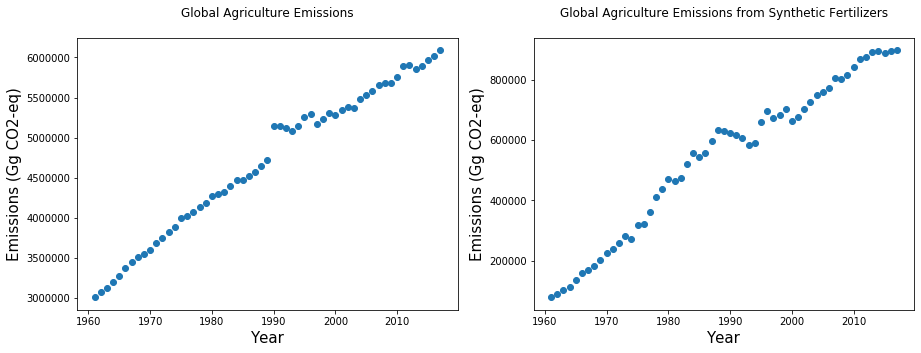

In [154]:
fig = plt.figure(figsize = (15, 5))

ax1 = fig.add_subplot(1, 2, 1)
plt.scatter(total_per_year.index.values, total_per_year.value)
ax1.set_xlabel("Year", fontsize=15)
ax1.set_ylabel("Emissions (Gg CO2-eq)", fontsize=15)
ax1.set_title("Global Agriculture Emissions\n")

ax2 = fig.add_subplot(1,2,2)
plt.scatter(fert_emissions.index.values, fert_emissions.value)
ax2.set_xlabel("Year", fontsize=15)
ax2.set_ylabel("Emissions (Gg CO2-eq)", fontsize=15)
ax2.set_title("Global Agriculture Emissions from Synthetic Fertilizers\n")

We can see that both are increasing (as expected) - although the emissions due to fertilizer appear to be slowing in increase over the last few years.

For global agricultural emissions, we can see that there is a weird jump roughly around the year 1990. Let's figure out why that is:

In [155]:
#First look for the exact year where the jump occurs
total_per_year.loc[1988:1992]

,area_code,element_code,item_code,year_code,value,note
year,,,,,,
1988,173018,10108938,7076127,2779224,4.642316e+06,0.0
1989,173018,10108938,7076127,2780622,4.717353e+06,0.0
1990,211837,12365010,8814324,3402900,5.146297e+06,0.0
1991,211170,12336086,8794098,3396646,5.140631e+06,0.0
1992,230556,13493046,9619349,3717072,5.125552e+06,0.0


We see above that the discontinuity occurs between 1989 and 1990.

One possible reason for this could be that data for more areas became available in this year - let's check:

In [156]:
emissions_1989 = total_emissions.query("year == 1989").groupby('area').sum()
countries_1989 = len(emissions_1989.index)
print(countries_1989)

195


In [157]:
emissions_1990 = total_emissions.query("year == 1990").groupby('area').sum()
countries_1990 = len(emissions_1990.index)
print(countries_1990)

208


It seems that our hypothesis was correct and the discontinuity can be explained by the addition of many more areas starting in 1990.

Now we want to continue our analysis on the relationship between yield and environmental impacts (and in particular environmental impacts of fertilizer).

In order to effectively compare impacts between countries, we will consider emissions per ha of agricultural land rather than total emissions, therefore first let's calculate this value:

In [158]:
total_area=pd.read_csv('./data/LandUse.csv',sep=',',encoding='latin-1')
total_area_agriculture = total_area.query("Item == 'Agriculture'")
total_area_agriculture.head(2)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
114,RL,Land Use,2,Afghanistan,5110,Area,6602,Agriculture,1961,1961,1000 ha,37700.0,Fc,Calculated data
115,RL,Land Use,2,Afghanistan,5110,Area,6602,Agriculture,1962,1962,1000 ha,37760.0,Fc,Calculated data


In [159]:
total_emissions = pd.merge(total_emissions, total_area_agriculture.loc[:,['Value', 'Area','Year']], left_on = ['area','year'], right_on = ['Area','Year'])
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5059,Manure Management,1961,1961,gigagrams,367.8310,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961


In [160]:
total_emissions['emissions_ha'] = total_emissions.value / total_emissions.Value
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year,emissions_ha
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961,0.134068
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5059,Manure Management,1961,1961,gigagrams,367.8310,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961,0.009757


### Checking for missing values
Next we will inspect the data set for missing values.

In [722]:
#let's check for missing values
missing_total = total_emissions[total_emissions.emissions_ha ==0].shape
total = total_emissions.shape
percent = (missing_total[0] / total[0])*100

print('There are %d values with %d equal to 0 which is %d percent'%(total[0], missing_total[0], percent))

There are 92067 values with 3157 equal to 0 which is 3 percent


We see that there is only 3 percent of missing values in the dataframe (for the value we are concerned with), which is not significant - therefore they can be dropped. However, we will first take a closer look at the missing values in the fertilizer emissions subset as this is the section we are most interested in:

In [723]:
#since we are only concerned with the fertilizer emissions, let's check how many of these are in fertilizer
emissions_fertilizer = total_emissions.query("item == 'Synthetic Fertilizers'")

emissions_missing = emissions_fertilizer[emissions_fertilizer.emissions_ha ==0].shape
emissions_total = emissions_fertilizer.shape
percent_emissions = (emissions_missing[0] / emissions_total[0])*100

print('There are %d values with %d equal to 0 which is %d percent'%(emissions_total[0], emissions_missing[0], percent_emissions))

There are 10043 values with 1153 equal to 0 which is 11 percent


There is a higher proportion of missing values in the fertilizer subset, but still relatively low. Let's see where the majority of these missing values are:

In [724]:
#let's see where these missing values are coming from (which country, which years)
emissions_fertilizer[emissions_fertilizer.emissions_ha ==0].groupby('year').count().sort_values('item', ascending = False)


,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,unit,value,flag,flag_description,note,Value,Area,Year,emissions_ha
year,,,,,,,,,,,,,,,,,,
1961,46,46,46,46,46,46,46,46,46,46,46,46,0,0,46,46,46,46
1962,46,46,46,46,46,46,46,46,46,46,46,46,0,0,46,46,46,46
1963,45,45,45,45,45,45,45,45,45,45,45,45,0,0,45,45,45,45
1964,43,43,43,43,43,43,43,43,43,43,43,43,0,0,43,43,43,43
1965,43,43,43,43,43,43,43,43,43,43,43,43,0,0,43,43,43,43
1966,40,40,40,40,40,40,40,40,40,40,40,40,0,0,40,40,40,40
1967,38,38,38,38,38,38,38,38,38,38,38,38,0,0,38,38,38,38
1968,38,38,38,38,38,38,38,38,38,38,38,38,0,0,38,38,38,38
1969,36,36,36,36,36,36,36,36,36,36,36,36,0,0,36,36,36,36


We can see that the number of missing values is dramatically lower from 2002 on and not too significant in any given year. We will drop the missing values since our focus will mostly focus from 2002 onwards for comparison with fertilizer use results (as this is when fertilizer use data is available from).

In [730]:
total_emissions = total_emissions[(total_emissions['emissions_ha'] != 0)]
emissions_fertilizer = emissions_fertilizer[(emissions_fertilizer['emissions_ha'] != 0)]

In [11]:
missing_2 = emissions_fertilizer[emissions_fertilizer.emissions_ha ==0].shape
print('There are %d values equal to 0'%(missing_2[0]))

There are 0 values equal to 0


## Function Definition

Next we define some functions used in our analysis:

In [14]:
# This function separate countries in three different groups according to their fertilizer emissions
def emissions_class(x, L): 
    ''' x is the emissions value, L is the set of emissions values'''
    if x<np.percentile(L,33):
        return 'low'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'medium'
    else:
        return 'high'

In [519]:
# This function separate countries in three different groups according to their fertilizer emissions
def emissions_color(x, L): 
    ''' x is the emissions value, L is the set of emissions values'''
    if x<np.percentile(L,33):
        return 'green'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'yellow'
    else:
        return 'red'

In [15]:
#This function performs umap dimensionality reduction on the data set over the years and compares to emissions data
def PCA_year_emissions(year):

    grouped_yield=crops.query('`Element Code` == 5419')\
    .query('`Year Code` == @year')\
    .query('`Item Code` >1000')\
    .query('`Area Code` <300')\
    .pivot(index='Area',columns='Item',values='Value')\
    .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])\
    .reset_index()

    grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    grouped_yield=grouped_yield.dropna(axis=0)
    grouped_yield=grouped_yield.reindex()
    
    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])

    #importation of emissions
    pca_emissions=(emissions_fertilizer
                    .query('Year == @year'))

    grouped_yield_pca=pd.merge(grouped_yield_pca,pca_emissions.loc[:,['Area','emissions_ha']],left_on='Area',right_on='Area')
    grouped_yield_pca.dropna(axis=0, inplace=True)
    grouped_yield_pca['emissions_class']=grouped_yield_pca.emissions_ha.apply(lambda x: emissions_class(x, grouped_yield_pca.emissions_ha))
    grouped_yield_pca.PC1=(grouped_yield_pca.PC1-min(grouped_yield_pca.PC1))/(max(grouped_yield_pca.PC1)-min(grouped_yield_pca.PC1))
    grouped_yield_pca.emissions_ha=(grouped_yield_pca.emissions_ha-min(grouped_yield_pca.emissions_ha))/(max(grouped_yield_pca.emissions_ha)-min(grouped_yield_pca.emissions_ha))
    
    
    
    coef = np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.emissions_ha,1)

    return year,grouped_yield_pca,coef # return year (for confirmation), performed PCA and value of linear regression

In [13]:
#This function performs umap dimensionality reduction on the data set over the years and compares to emissions data
def umap_year_emissions(year, n_components=2): 
    yield_for_merge=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .query('`Area Code` <300') # Exclusion of grouped areas
            .pivot(index='Area',columns='Item',values='Value')
            .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])# drop columns with to many missing values
            .reset_index()
            
              )
    yield_for_merge['Cereal']=yield_for_merge.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    yield_for_merge.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    yield_for_merge=yield_for_merge.dropna(axis=0)
    yield_for_umap=yield_for_merge.drop('Area',axis=1).values 
    
    #Normalization 
    x = yield_for_umap
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    yield_for_umap = pd.DataFrame(x_scaled)
    
    reducer = umap.UMAP(random_state=1, n_components= n_components)
    embedding = reducer.fit_transform(yield_for_umap)
    embedding2=pd.DataFrame(embedding)
    embedding2=pd.merge(embedding2,yield_for_merge['Area'], left_index=True, right_index=True)
    
    #importation of emissions
    umap_emissions=(emissions_fertilizer
                    .query('Year == @year'))
    embedding2=pd.merge(embedding2,umap_emissions.loc[:,['Area','emissions_ha']],left_on='Area',right_on='Area')
    
    #Result normalization to be able to compare them between years
    embedding2[0]=(embedding2[0]-min(embedding2[0]))/(max(embedding2[0])-min(embedding2[0]))
    embedding2.rename(columns={0: "Umap"}, inplace=True)
    embedding2['emissions_ha']=(embedding2['emissions_ha']-min(embedding2['emissions_ha']))/(max(embedding2['emissions_ha'])-min(embedding2['emissions_ha']))
    embedding2['emissions_class']=embedding2.emissions_ha.apply(lambda x: emissions_class(x, embedding2.emissions_ha))
    
    coef = np.polyfit(embedding2['Umap'],embedding2.emissions_ha,1)
    
    return year,embedding2,coef # return year (for confirmation), performed umap and value of linear regression

In [14]:
def emissions_class_2(x, L): 
    ''' x is the emissions value, L is the set of emissions values'''
    if x<np.percentile(L,33):
        return 0
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 1
    else:
        return 2

## UMAP Analysis

We will perform a umap dimensionality reduction to 2 dimensions on the yield data and visualize this in relation to the emissions classifications, therefore we will also load the yield dataset and prepare it for the dimensionality reduction analysis:

In [734]:
#Prepare the yield dataset for umap dimensional reduction analysis:

grouped_yield = crops.query('`Element Code` == 5419').query('`Item Code` >1000')
grouped_yield = crops.groupby(['Item','Year']).sum()

grouped_yield_2016=(crops.query('`Element Code` == 5419') #by yield
        .query('`Year Code` == 2016') 
        .query('`Item Code` >1000') #grouped crops
        .pivot(index='Area',columns='Item',values='Value')
        .fillna(value=0)
        .reset_index()
          )
grouped_yield_2016.head(2)

Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,Afghanistan,19391.0,19816.0,83127.0,16667.0,3727.681319,88201.0,6868.32967,4060.164835,7406.0,119868.0,15984.0,91869.0
1,Africa,14245.0,15261.0,108260.0,13007.0,0.000000,88514.0,0.00000,0.000000,7629.0,85875.0,5437.0,83707.0


In [735]:
yield_2016 = grouped_yield_2016.drop('Area',axis=1).values

#Normalization 
from sklearn import preprocessing

x = yield_2016
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
yield_2016 = pd.DataFrame(x_scaled)

For a first analysis, we will look at the year 2016 - therefore we will first isolate the emissions from this year, starting with all emissions:

In [736]:
emissions_2016 = total_emissions.query('year == 2016').groupby('area').sum()
emissions_2016.head(2)

,area_code,element_code,item_code,year_code,year,value,note,Value,Year,emissions_ha
area,,,,,,,,,,
Afghanistan,18,65079,45560,18144,18144,13832.9964,0.0,341190.0,18144,0.364890
Albania,27,65079,47259,18144,18144,2924.0750,0.0,10635.3,18144,2.474465


Next we apply umap to the data and classify in terms of emissions:

In [747]:
import umap

reducer = umap.UMAP(random_state=1)
embedding = reducer.fit_transform(yield_2016)
embedding2=pd.DataFrame(embedding)
embedding2=pd.merge(embedding2,grouped_yield_2016['Area'], left_index=True, right_index=True)
embedding2=pd.merge(embedding2,emissions_2016.loc[:,['emissions_ha']],left_on='Area',right_index = True)
embedding2['emissions_class']=embedding2.emissions_ha.apply(lambda x: emissions_class(x, embedding2.emissions_ha))
embedding2['emissions_class2']=embedding2.emissions_ha.apply(lambda x: emissions_class_2(x, embedding2.emissions_ha))
embedding2.head(2)

,0,1,Area,emissions_ha,emissions_class,emissions_class2
0,-0.977878,3.675343,Afghanistan,0.364890,low,0
2,-2.673802,2.858271,Albania,2.474465,high,2


Finally we visualize the umap results and the distribution with respect to each emissions class.

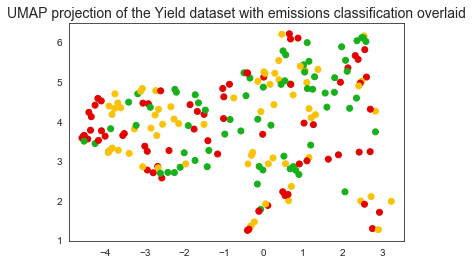

In [748]:
#Visualize 
plt.scatter(embedding2[0], embedding2[1], c=[sns.xkcd_palette(colors)[x] for x in embedding2.emissions_class2.values])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Yield dataset with emissions classification overlaid', fontsize=14);

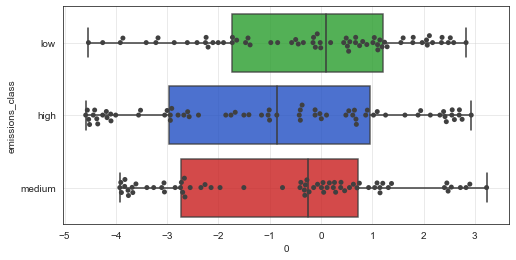

In [751]:
#Box plot x axis
fig = plt.figure(figsize = (8,4))

colors = ["green", "blue", "red"]
#cmap = sns.cubehelix_palette(rot=-.4)
ax = sns.boxplot(x=embedding2[0], y='emissions_class', data=embedding2, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2[0], y='emissions_class', data=embedding2, color=".25")
ax.grid(alpha=0.5)

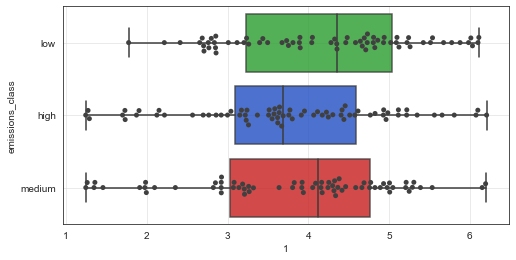

In [752]:
#Box plot y axis
fig = plt.figure(figsize = (8,4))
#sns.palplot(sns.cubehelix_palette(3))
colors = ["green", "blue", "red"]
ax = sns.boxplot(x=embedding2[1], y='emissions_class', data=embedding2, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2[1], y='emissions_class', data=embedding2, color=".25")
ax.grid(alpha=0.5)

We can see above that considering overall emissions, there is not a very notable difference between the yield characteristics of the low, medium and high emissions groups. 

This could be interesting in itself - however, it should be noted that for yield we are only considering crops, whereas overall emissions are highly affected by agricultural practices (such as burning), as well as livestock. Therefore, in a way it makes sense that the yield of crops does not differentiate between these groups.

However, the situation may be different if we consider the emissions due to fertilizers only - let's look at this:

In [753]:
fert_emissions_2016 = total_emissions.query("item == 'Synthetic Fertilizers'").query('year == 2016').groupby('area').sum()
fert_emissions_2016.head(2)

,area_code,element_code,item_code,year_code,year,value,note,Value,Year,emissions_ha
area,,,,,,,,,,
Afghanistan,2,7231,5061,2016,2016,623.9758,0.0,37910.0,2016,0.016459
Albania,3,7231,5061,2016,2016,276.8789,0.0,1181.7,2016,0.234306


In [755]:
#perform a new umap analysis
reducer_new = umap.UMAP(random_state=1)
embedding_new = reducer_new.fit_transform(yield_2016)
embedding2_new=pd.DataFrame(embedding_new)
embedding2_new=pd.merge(embedding2_new,grouped_yield_2016['Area'], left_index=True, right_index=True)
embedding2_new=pd.merge(embedding2_new,fert_emissions_2016.loc[:,['emissions_ha']],left_on='Area',right_index = True)
embedding2_new['emissions_class']=embedding2_new.emissions_ha.apply(lambda x: emissions_class(x, embedding2_new.emissions_ha))
embedding2_new['emissions_class2']=embedding2_new.emissions_ha.apply(lambda x: emissions_class_2(x, embedding2_new.emissions_ha))
embedding2_new.head(2)

,0,1,Area,emissions_ha,emissions_class,emissions_class2
0,-0.977878,3.675343,Afghanistan,0.016459,low,0
2,-2.673802,2.858271,Albania,0.234306,medium,1


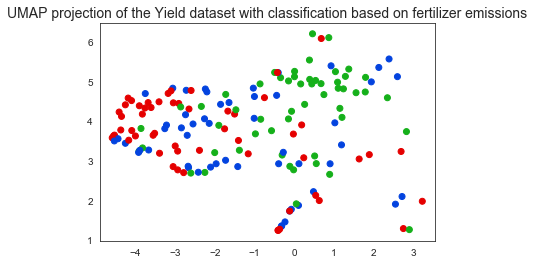

In [756]:
plt.scatter(embedding2_new[0], embedding2_new[1], c=[sns.xkcd_palette(colors)[x] for x in embedding2_new.emissions_class2.values])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Yield dataset with classification based on fertilizer emissions', fontsize=14);

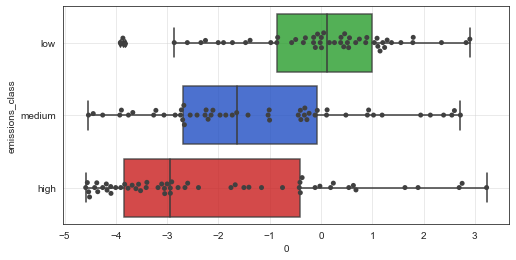

In [757]:
#Box plot x axis
fig = plt.figure(figsize = (8,4))

colors = ["green", "blue", "red"]
ax = sns.boxplot(x=embedding2_new[0], y='emissions_class', data=embedding2_new, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2_new[0], y='emissions_class', data=embedding2_new, color=".25")
ax.grid(alpha=0.5)

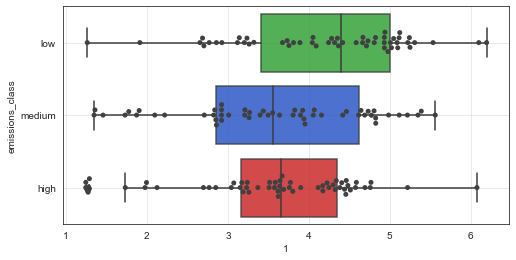

In [759]:
#Box plot y axis
fig = plt.figure(figsize = (8,4))

colors = ["green", "blue", "red"]
ax = sns.boxplot(x=embedding2_new[1], y='emissions_class', data=embedding2_new, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2_new[1], y='emissions_class', data=embedding2_new, color=".25")
ax.grid(alpha=0.5)

Looking at the plots above, we see that considering fertilizer emissions, there is a notable difference betweem the low and medium/high emissions categories when compared to the reduced dimensionality x value, and a notable difference between the low and the medium/high emissions categories when compared to the reduced dimensionality y value.


Next we want to consider further the differences and similarities between these groups.
For example, what are the differences between groups and why?
Which places are 'outliers', with similar yield characteristics but drastically different emissions, or vice versa?

Initially, we take a deeper look at these outlier cases:

For example, inspecting the "low" emissions group, we find that Australia has synthetic fertilizer emissions in the low range, but has yield characteristics more similar to that of countries with medium to high emissions such as spain:

For example, inspecting the "low" emissions group, we find that Australia has synthetic fertilizer emissions in the low range, but has yield characteristics more similar to that of countries with medium to high emissions such as spain:

In [760]:
embedding2_new.query("Area == ['Australia','Spain']")

,0,1,Area,emissions_ha,emissions_class,emissions_class2
11,-2.251897,2.703403,Australia,0.018335,low,0
207,-1.967824,2.921457,Spain,0.241359,medium,1


Let's take a closer look at the data we have for emissions and crop yields of these countries:

In [761]:
fert_emissions_2016.query("area == ['Australia','Spain']")

,area_code,element_code,item_code,year_code,year,value,note,Value,Year,emissions_ha
area,,,,,,,,,,
Australia,10,7231,5061,2016,2016,6803.8569,0.0,371078.0,2016,0.018335
Spain,203,7231,5061,2016,2016,6339.4598,0.0,26265.7,2016,0.241359


In [762]:
grouped_yield_2016.query("Area == ['Australia','Spain']")

Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
11,Australia,20698.0,20752.0,199756.0,22375.0,19910.230769,142540.0,8784.659341,4921.505495,11965.0,401728.0,17488.0,258512.0
207,Spain,38179.0,38625.0,239620.0,39736.0,5728.000000,122106.0,6009.054945,5716.241758,13873.0,309510.0,3796.0,391402.0


Above we can see that Australia has a similar value of absolute value of emissions as well as a larger agricultural area than Spain, ultimately leading it to have a much lower value of emissions per ha of agricultural area. 

And the yield data is indeed similar, with some exceptions (notably Spain produces more grains and vegetables, and Australia produces more roots and tubers and treenuts).

This is interesting, however it should be noted that the goal of our analysis is more to provide a global overview and therefore we will not explore this in complete depth, and instead turn to performing our analysis over multiple years.

Our next step is to extend the umap analysis across multiple years using the umap year function defined above, and plot figures for analysis of the results:

Text(0, 0.5, 'Interpolation Coef')

<Figure size 1440x1080 with 0 Axes>

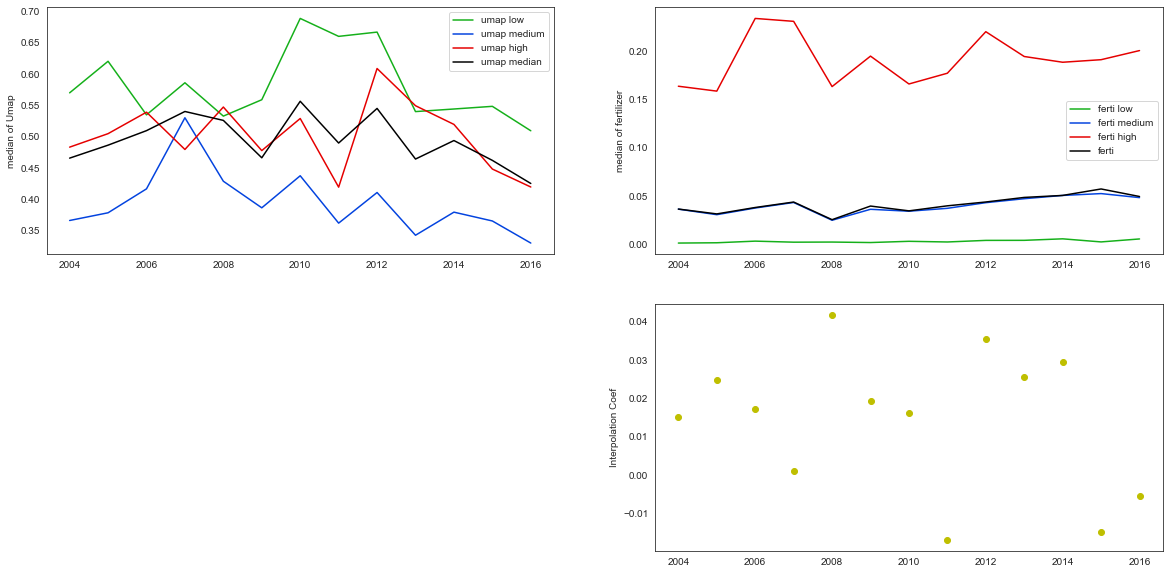

In [765]:
fig = plt.figure(figsize = (20, 15))
fig.suptitle('Evolution of the interpolation coefficient of each fertilizer over the year ', fontsize=25)

umap_plot=[]
for year in range(2004, 2017):
    umap_result=umap_year_emissions(year,1)
    low_median=umap_result[1].emissions_ha[umap_result[1].emissions_class=='low'].median()
    medium_median=umap_result[1].emissions_ha[umap_result[1].emissions_class=='medium'].median()
    high_median=umap_result[1].emissions_ha[umap_result[1].emissions_class=='high'].median()
    ferti_median=umap_result[1].emissions_ha.median()
    
    umap_low_median=umap_result[1].Umap[umap_result[1].emissions_class=='low'].median()
    umap_medium_median=umap_result[1].Umap[umap_result[1].emissions_class=='medium'].median()
    umap_high_median=umap_result[1].Umap[umap_result[1].emissions_class=='high'].median()
    umap_median=umap_result[1].Umap.median()
    
    umap_plot.append([umap_result[0],umap_result[2][0],low_median,medium_median,high_median,ferti_median,
                         umap_low_median,umap_medium_median,umap_high_median,umap_median])
    
umap_plot=pd.DataFrame(umap_plot, 
                          columns= ['Year','Coef','ferti low','ferti medium','ferti high','ferti',
                                          'umap low','umap medium','umap high','umap median'])

colors = ["green", "blue", "red"]

figure = plt.figure(figsize = (20,10))
ax1 = figure.add_subplot(2,2,1)
ax1.plot("Year", "umap low", data=umap_plot, color=sns.xkcd_palette(colors)[0])
ax1.plot("Year", "umap medium", data=umap_plot, color=sns.xkcd_palette(colors)[1])
ax1.plot("Year", "umap high", data=umap_plot, color=sns.xkcd_palette(colors)[2])
ax1.plot("Year", "umap median", data=umap_plot, color=sns.xkcd_rgb["black"])
ax1.set_ylabel('median of Umap')
ax1.legend()

ax2 = figure.add_subplot(2,2,2)
ax2.plot("Year", "ferti low", data=umap_plot, color=sns.xkcd_palette(colors)[0])
ax2.plot("Year", "ferti medium", data=umap_plot, color=sns.xkcd_palette(colors)[1])
ax2.plot("Year", "ferti high", data=umap_plot, color=sns.xkcd_palette(colors)[2])
ax2.plot("Year", "ferti", data=umap_plot, color=sns.xkcd_rgb["black"])
ax2.set_ylabel('median of fertilizer')
ax2.legend()

ax4 = figure.add_subplot(2,2,4)
ax4.plot("Year", 'Coef', 'yo', data=umap_plot)
ax4.set_ylabel('Interpolation Coef')

Here we can see that the relationship between the umap paramter and emissions is difficult to interpret (for exmaple it is not easy to identify how the umap paramter represents yield, and what information we gain from comparing this to emissions). We therefore proceed the rest of the analysis using PCA which is easier to interpret and share results from.

## PCA Analysis:

First we apply the PCA analysis to one year to get an idea of how the method and results look:

In [771]:
#pca for 1 year:
grouped_yield=crops.query('`Element Code` == 5419')\
.query('`Year Code` == 2016')\
.query('`Item Code` >1000')\
.query('`Area Code` <300')\
.pivot(index='Area',columns='Item',values='Value')\
.drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])\
.reset_index()


grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
grouped_yield=grouped_yield.dropna(axis=0)
grouped_yield=grouped_yield.reindex()

emissions_fert_2016 = emissions_fertilizer.query("year == 2016")

pca,pca_one = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])
pca_one=pd.merge(pca_one,emissions_fert_2016.loc[:,['Area','emissions_ha']],left_on='Area',right_on='Area')
pca_one['emissions_class']=pca_one.emissions_ha.apply(lambda x: emissions_class(x, pca_one.emissions_ha))


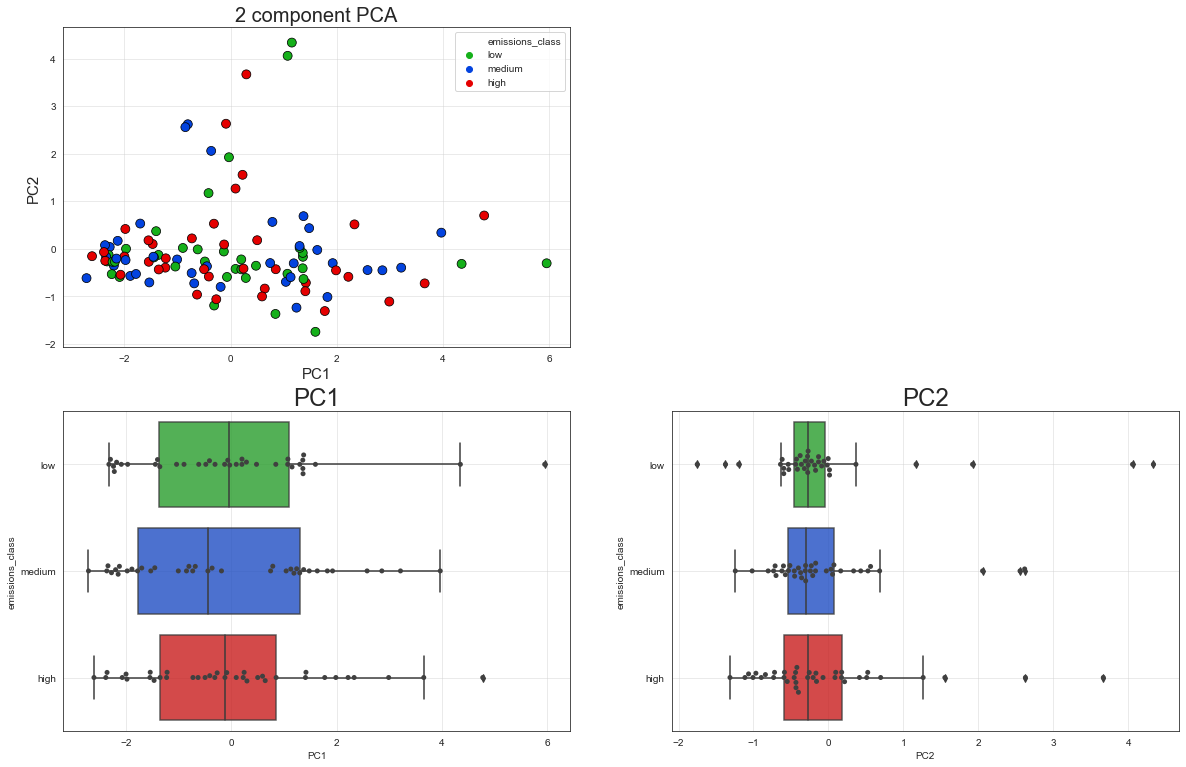

In [773]:
#Viz for 1 year 
figure = plt.figure(figsize = (20,20))
colors = ["green", "blue", "red"]

ax1 = figure.add_subplot(3,2,1)
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('2 component PCA', fontsize = 20)
ax1.grid(alpha=0.5)
ax1 = sns.scatterplot(x='PC1', y='PC2', hue='emissions_class', palette=sns.xkcd_palette(colors), data=pca_one, s=80,edgecolor="black")

ax2 = figure.add_subplot(3,2,3)
ax2 = sns.boxplot(x='PC1', y='emissions_class', data=pca_one, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax2 = sns.swarmplot(x='PC1', y='emissions_class', data=pca_one, color=".25")
ax2.grid(alpha=0.5)
plt.title('PC1', fontsize=24);

ax3 = figure.add_subplot(3,2,4)
ax3 = sns.boxplot(x='PC2', y='emissions_class', data=pca_one, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax3 = sns.swarmplot(x='PC2', y='emissions_class', data=pca_one, color=".25")
ax3.grid(alpha=0.5)
plt.title('PC2', fontsize=24);

Here the most interesting thing to note is the lack of significant differences in PCA parameters between countries with varying emissions - indicating that potentially emissions and yield are not as linked as we might initially think. 

We now extend the PCA analysis to multiple years to further analyze this:

In [782]:
years = []
PC1_low = []
PC1_medium = []
PC1_high = []
PC1 = []
emissions_low = []
emissions_medium = []
emissions_high = []
emissions = []
emissions_effect = []
proportion_explained = []
test = []


for year in range(2002,2016):
    years += [year]
    
    grouped_yield=crops.query('`Element Code` == 5419')\
        .query('`Year Code` == @year')\
        .query('`Item Code` >1000')\
        .query('`Area Code` <300')\
        .pivot(index='Area',columns='Item',values='Value')\
        .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])\
        .reset_index()

    grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    grouped_yield=grouped_yield.dropna(axis=0)
    grouped_yield=grouped_yield.reset_index()
    grouped_yield.drop(columns=['index'],inplace=True)
    
    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])


    #importation of emissions
    pca_emissions=(emissions_fertilizer
                    .query('Year == @year'))
    
    grouped_yield_pca=pd.merge(grouped_yield_pca,pca_emissions.loc[:,['Area','emissions_ha']],left_on='Area',right_on='Area')
    grouped_yield_pca['emissions_class']=grouped_yield_pca.emissions_ha.apply(lambda x: emissions_class(x, grouped_yield_pca.emissions_ha))
    
    PC1_low += [grouped_yield_pca.PC1[grouped_yield_pca.emissions_class=='low'].median()]
    PC1_medium += [grouped_yield_pca.PC1[grouped_yield_pca.emissions_class=='medium'].median()]
    PC1_high += [grouped_yield_pca.PC1[grouped_yield_pca.emissions_class=='high'].median()]
    PC1 += [grouped_yield_pca.PC1.median()]
    #test += [grouped_yield_pca.PC1.median()/emissions_ha.median()]
    
    
    #print(len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='low']),len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='medium']),len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='high']))
    emissions_low += [grouped_yield_pca.emissions_ha[grouped_yield_pca.emissions_class=='low'].median()]
    emissions_medium += [grouped_yield_pca.emissions_ha[grouped_yield_pca.emissions_class=='medium'].median()]
    emissions_high += [grouped_yield_pca.emissions_ha[grouped_yield_pca.emissions_class=='high'].median()]
    
    emissions += [grouped_yield_pca.emissions_ha.median()]
    
    grouped_yield_pca.dropna(axis=0, inplace=True)
    grouped_yield_pca.PC1=(grouped_yield_pca.PC1-min(grouped_yield_pca.PC1))/(max(grouped_yield_pca.PC1)-min(grouped_yield_pca.PC1))
    
    emissions_effect += [np.poly1d(np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.emissions_ha,1))[1]]
    proportion_explained += [pca.explained_variance_ratio_[0]]

Text(0, 0.5, 'emissions effect')

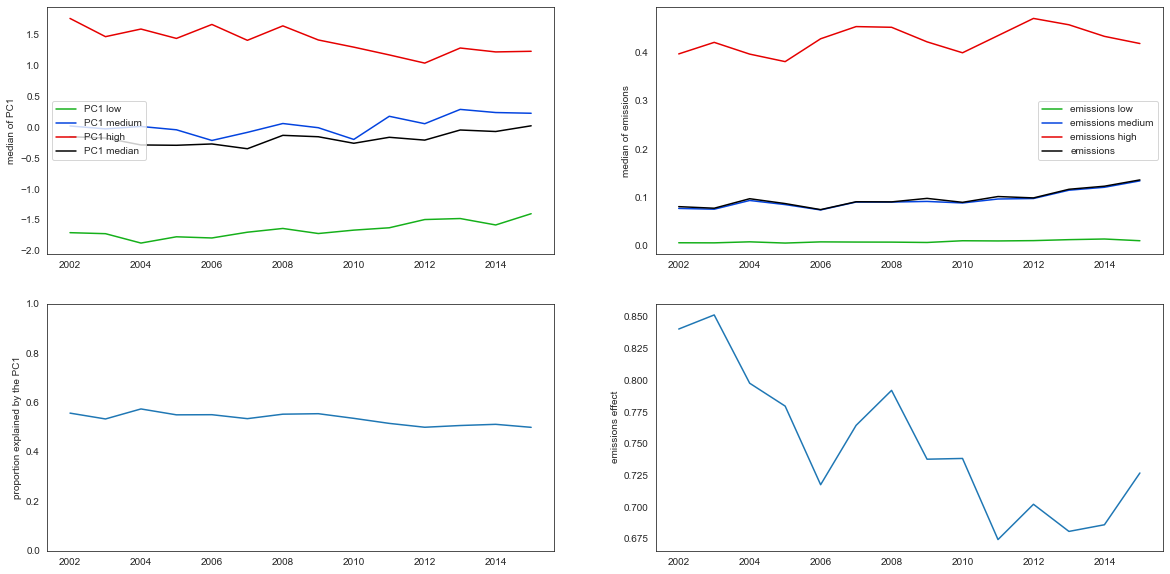

In [785]:
evolution_emissions = pd.DataFrame([years, PC1_low, PC1_medium, PC1_high, ferti_low, emissions_medium, emissions_high,emissions,PC1, proportion_explained, emissions_effect], ['year', 'PC1 low', 'PC1 medium', 'PC1 high','emissions low', 'emissions medium', 'emissions high','emissions','PC1 median', 'proportion explained', 'emissions effect']).T
colors = ["green", "blue", "red"]

figure = plt.figure(figsize = (20,10))
ax1 = figure.add_subplot(2,2,1)
ax1.plot("year", "PC1 low", data=evolution_emissions, color=sns.xkcd_palette(colors)[0])
ax1.plot("year", "PC1 medium", data=evolution_emissions, color=sns.xkcd_palette(colors)[1])
ax1.plot("year", "PC1 high", data=evolution_emissions, color=sns.xkcd_palette(colors)[2])
ax1.plot("year", "PC1 median", data=evolution_emissions, color=sns.xkcd_rgb["black"])
ax1.set_ylabel('median of PC1')
ax1.legend(loc = 'center left')

ax2 = figure.add_subplot(2,2,2)
ax2.plot("year", "emissions low", data=evolution_emissions, color=sns.xkcd_palette(colors)[0])
ax2.plot("year", "emissions medium", data=evolution_emissions, color=sns.xkcd_palette(colors)[1])
ax2.plot("year", "emissions high", data=evolution_emissions, color=sns.xkcd_palette(colors)[2])
ax2.plot("year", "emissions", data=evolution_emissions, color=sns.xkcd_rgb["black"])
ax2.set_ylabel('median of emissions')
ax2.legend()

ax3 = figure.add_subplot(2,2,3)
ax3.plot("year", 'proportion explained', data=evolution_emissions)
ax3.set_ylabel('proportion explained by the PC1')
ax3.set_ylim([0,1])

ax4 = figure.add_subplot(2,2,4)
ax4.plot("year", 'emissions effect', data=evolution_emissions)
ax4.set_ylabel('emissions effect')

Above we can see that the link between emissions and yield remains unclear when extended to multiple years. The low emissions group has approximately constant emissions and increasing yield, and the high emissions group has periods of increasing yield and decreasing emissions, and vice versa. Clearly high emissions is not necessarily (or not always) related to improved agriculture - an important fact considering the need to reduce agricultural emissions while continuing to feed a growing population.

## Further Analysis and Plots Preparation

Now that we have found an interesting relationship, we will prepare further plots to show this finding in our data story as well as further explore the relationships.

## Data frame for fertilizer emissions over the years per country:

In [786]:
#emissions dataframe
emissions_year=pd.DataFrame(columns=['area'])
years = np.array([range(2002,2018)]).astype(str)

for year in range(2002,2018):#emissions_fertilizer.pivot_table(index=['year_code']).index :
    emissions=(emissions_fertilizer
            .query('`year_code` == @year')
            .pivot(index='area',columns = 'year_code',values='emissions_ha')
            .dropna(axis=0)
            .reset_index()
              )
    emissions.dropna(axis=0, inplace=True)
    emissions_year=emissions.merge(emissions_year, on='area',how='outer')

emissions_year.dropna(inplace = True)
emissions_year.columns = emissions_year.columns.astype(str)
emissions_year.head(2)

,area,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
0,Afghanistan,0.023969,0.016459,0.003588,0.012578,0.005943,0.002906,0.003911,0.002201,0.002410,0.002457,0.002788,0.003484,0.003485,0.003804,0.003475,0.004193
1,Albania,0.216326,0.234306,0.202296,0.168811,0.166962,0.187756,0.198276,0.168136,0.182362,0.157102,0.181606,0.174816,0.223010,0.207790,0.215222,0.216383


In [787]:
emissions_year_2 = emissions_year.T
emissions_year_2.rename(columns=emissions_year_2.iloc[0], inplace = True)
emissions_year_2.drop(emissions_year_2.index[0], inplace = True)
emissions_year_2.dropna(axis = 'columns', inplace = True)
emissions_year_2.sort_index(inplace = True)
emissions_year_2.head(2)

,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,...,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
2002,0.0041928,0.216383,0.00454052,0.00031008,0.0268091,0.0728526,0.0141526,0.380255,0.0214266,0.580533,...,0.430031,0.00418835,0.171031,0.0112449,0.133408,0.0569351,0.775278,0.00308326,0.0115117,0.0295161
2003,0.00347454,0.215222,0.002762,0.000200285,0.0365263,0.0467112,0.0137009,0.668554,0.0170862,1.64415,...,0.428254,0.00500814,0.180292,0.0285039,0.134307,0.0575344,0.840039,0.00135109,0.0120635,0.0319635


Text(0.5, 0, 'Year')

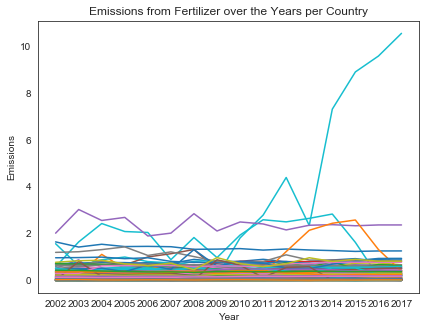

In [788]:
figure = plt.figure(figsize = (15,5))
ax1 = figure.add_subplot(1,2,1)


for x in range(0, emissions_year_2.shape[1]):
    ax1.plot(emissions_year_2.index, emissions_year_2.iloc[:,x])

ax1.set_title('Emissions from Fertilizer over the Years per Country')
ax1.set_ylabel('Emissions')
ax1.set_xlabel('Year')

One interesting thing to note is the significant rise of one country - we will check what this country is:

In [64]:
emissions_year[emissions_year['2016'] > 2]

,area,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
34,"China, Hong Kong SAR",10.542040,9.573560,8.896667,7.308961,2.346392,4.393059,2.788400,1.814345,0.163517,0.426000,0.749817,0.804683,0.998629,0.882443,0.622414,1.566629
51,Egypt,2.367983,2.367983,2.332931,2.379826,2.355047,2.155582,2.410167,2.495033,2.109501,2.847678,2.018415,1.897071,2.689774,2.558832,3.026404,2.017144


We can see that this country is hong kong whose emissions have been steadily increasing since around 2009.

We now also create a dataframe containing the emissions classification of each country and their average emissions value to use in later analysis:

In [346]:
emissions_year_class = emissions_year.copy().set_index('area')
emissions_year_class['mean'] = emissions_year_class.mean(axis = 1)
emissions_year_class['emissions_class'] = emissions_year_class['mean'].apply(lambda x: emissions_class(x, emissions_year_class['mean']))
emissions_year_class.head(2)

,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,mean,emissions_class
area,,,,,,,,,,,,,,,,,,
Afghanistan,0.023969,0.016459,0.003588,0.012578,0.005943,0.002906,0.003911,0.002201,0.002410,0.002457,0.002788,0.003484,0.003485,0.003804,0.003475,0.004193,0.006103,low
Albania,0.216326,0.234306,0.202296,0.168811,0.166962,0.187756,0.198276,0.168136,0.182362,0.157102,0.181606,0.174816,0.223010,0.207790,0.215222,0.216383,0.193822,medium


In [350]:
emissions_class_df = emissions_year_class.loc[:,['mean','emissions_class']]
emissions_class_df.head(2)

,mean,emissions_class
area,,
Afghanistan,0.006103,low
Albania,0.193822,medium


## Analysis of the relationship between fertilizer use and emissions

Based on the analysis above, we can see that there are some differences between the relationship between emissions - yield and fertilizer use - yield. This is interesting as in theory we would expect them to be almost perfectly correlated, since it is fertilizer application that results directly in the synthetic fertilizer emissions (which are due to N2O emissions caused by fertilizer application)

Therefore, we will study this relationship:

In [789]:
#First we generate a data frame that can be used to determine the correlation for each country over the years

ferti_corr = correlation.iloc[:,~correlation.columns.str.endswith('_emiss')] 
ferti_corr.columns = ferti_corr.columns.str.replace('_ferti', '')


emiss_corr = correlation.iloc[:,~correlation.columns.str.endswith('_ferti')] 
emiss_corr.columns = emiss_corr.columns.str.replace('_emiss', '')


emiss_corr = emiss_corr.T
emiss_corr.rename(columns=emiss_corr.loc['area'], inplace = True)
emiss_corr.columns += '_emiss'
emiss_corr.drop(emiss_corr.index[0], inplace = True)
emiss_corr.sort_index(inplace = True)
emiss_corr = emiss_corr.astype(float)

ferti_corr_2 = ferti_corr.T
ferti_corr_2.rename(columns=ferti_corr_2.loc['area'], inplace = True)
ferti_corr_2.columns += '_ferti'
ferti_corr_2.drop(ferti_corr_2.index[0], inplace = True)
ferti_corr_2.sort_index(inplace = True)
ferti_corr_2 = ferti_corr_2.astype(float)

matrix = correlation_2.corr()
matrix.head(2)

,Afghanistan_emiss,Albania_emiss,Algeria_emiss,Angola_emiss,Argentina_emiss,Armenia_emiss,Australia_emiss,Austria_emiss,Azerbaijan_emiss,Bangladesh_emiss,...,United Kingdom_ferti,United Republic of Tanzania_ferti,United States of America_ferti,Uruguay_ferti,Uzbekistan_ferti,Venezuela (Bolivarian Republic of)_ferti,Viet Nam_ferti,Yemen_ferti,Zambia_ferti,Zimbabwe_ferti
Afghanistan_emiss,1.000000,0.372315,0.356199,0.594920,0.451509,0.716969,0.457262,0.068265,0.034671,0.305024,...,-0.744341,-0.158869,-0.651376,-0.408034,-0.567779,-0.773818,-0.532715,-0.222313,0.154202,-0.700151
Albania_emiss,0.372315,1.000000,-0.025867,-0.124183,0.106277,0.271291,0.052799,0.422417,-0.410688,-0.312498,...,-0.097419,-0.297085,-0.290858,-0.479220,-0.285641,-0.147521,-0.071401,-0.603313,0.161627,-0.066819


In [790]:
#now we drop the rows comparing the datasets to each other 
matrix = matrix.iloc[:, ~matrix.columns.str.endswith('_ferti')]
matrix = matrix[~matrix.index.str.endswith('_emiss')]
matrix.head(2)

,Afghanistan_emiss,Albania_emiss,Algeria_emiss,Angola_emiss,Argentina_emiss,Armenia_emiss,Australia_emiss,Austria_emiss,Azerbaijan_emiss,Bangladesh_emiss,...,United Kingdom_emiss,United Republic of Tanzania_emiss,United States of America_emiss,Uruguay_emiss,Uzbekistan_emiss,Venezuela (Bolivarian Republic of)_emiss,Viet Nam_emiss,Yemen_emiss,Zambia_emiss,Zimbabwe_emiss
Afghanistan_ferti,-0.055915,-0.172949,0.398288,0.480291,-0.163756,0.373306,0.579111,-0.092818,0.423151,0.235039,...,-0.136456,0.302148,0.670223,0.722425,0.447401,0.111683,0.121123,0.115097,0.307212,-0.585470
Albania_ferti,-0.619141,0.135406,-0.149836,-0.355904,-0.361672,-0.192972,-0.081260,0.121774,0.191849,-0.289647,...,0.299017,-0.362860,-0.115946,-0.221617,-0.276869,-0.148765,0.014558,-0.128313,-0.401795,0.067264


In [791]:
#Finally we create a dataset which contains only the correlation of one country to another
#(i.e. comparing one country's fertilizer use to it's emissions from fertilizer)

emiss_ferti_corr = pd.DataFrame(correlation.area)

corr_1 = [0]*len(matrix)

for i in range(134):
    corr_1[i] += matrix.iloc[i][i]

corr_2 = pd.DataFrame(corr_1)

emiss_ferti_corr = pd.merge(emiss_ferti_corr, corr_2, left_index = True, right_index = True)
emiss_ferti_corr.rename(columns={"area": "area", "0": "correlation"}, inplace = True)
emiss_ferti_corr.head(2)

,area,0
0,Afghanistan,-0.055915
1,Albania,0.135406


In [427]:
#We merge this information with the emissions_class dataset we created previously for comparison
emiss_ferti_corr = pd.merge(emiss_ferti_corr, emissions_class_df, left_on = 'area', right_on = 'area')
emiss_ferti_corr.head(2)

,area,0,mean,emissions_class
0,Afghanistan,-0.055915,0.006103,low
1,Albania,0.135406,0.193822,medium


In [828]:
#We also merge it with information regarding the fertilizer application 
ferti_corr.set_index('area', inplace = True)
ferti_corr = ferti_corr.astype(float)
ferti_corr['mean'] = ferti_corr.mean(axis = 1)
ferti_corr['ferti'] = ferti_corr['mean'].apply(lambda x: ferti_class(x, ferti_corr['mean']))
ferti_class = ferti_corr.loc[:, ['mean', 'ferti']]
emiss_ferti_corr_2 = pd.merge(emiss_ferti_corr, ferti_class, left_on = 'area', right_index = True)

In [829]:
emiss_ferti_corr_2.head(2)

,area,0,mean_x,emissions_class,mean_y,ferti
0,Afghanistan,-0.055915,0.006103,low,7.285248,low
1,Albania,0.135406,0.193822,medium,46.472895,medium


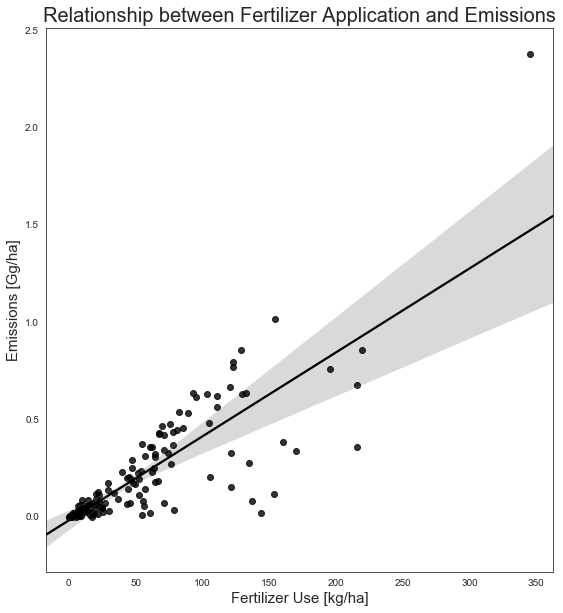

In [700]:
#Plot the relationship between fertilizer application and emissions
sns.set_style("white")
figure = plt.figure(figsize = (20,10))

ax1 = figure.add_subplot(1,2,1)

ax1 = sns.regplot(emiss_ferti_corr_2.mean_y, emiss_ferti_corr_2.mean_x,scatter=True, fit_reg=True, ci=95, color = 'black')
ax1.set_xlabel('Fertilizer Use [kg/ha]', fontsize = 15)
ax1.set_ylabel('Emissions [Gg/ha]', fontsize = 15)
ax1.set_title('Relationship between Fertilizer Application and Emissions', fontsize = 20)

plt.savefig('Fertilizer_Emissions.png')


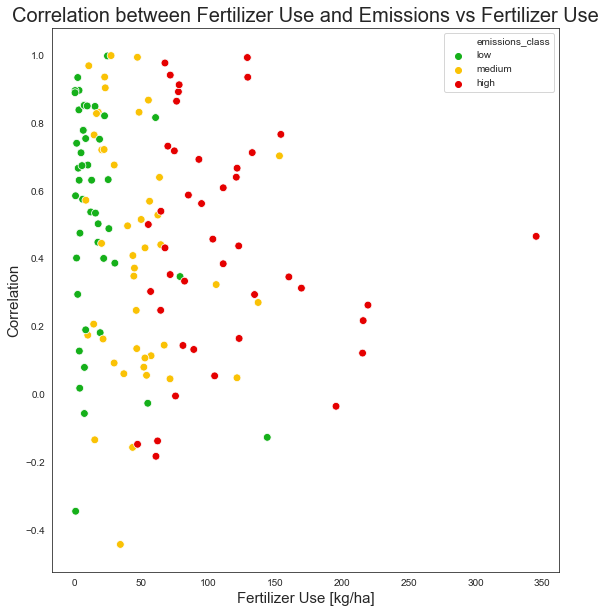

In [713]:
#Plot the correlation factor verses fertilizer use and colour based on emissions classification
sns.set_style("white")
figure = plt.figure(figsize = (20,10))
colors = ['green','goldenrod','red']

ax1 = figure.add_subplot(1,2,1)
ax1.set_title('Correlation between Fertilizer Use and Emissions vs Fertilizer Use', fontsize = 20)
ax1.grid(alpha=0.5)
ax1 = sns.scatterplot(emiss_ferti_corr_2.mean_y, emiss_ferti_corr_2[0], hue='emissions_class', palette=sns.xkcd_palette(colors), data=emiss_ferti_corr_2, s=60)
ax1.set_xlabel('Fertilizer Use [kg/ha]', fontsize = 15)
ax1.set_ylabel('Correlation', fontsize = 15)
plt.grid(None)

plt.savefig('Correlation_Fertilizer.png')

From these plots we can first see that in general fertilizer emissions do increase with fertilizer use, however this relationship is less evident at higher fetilizer application areas. Further, looking at the pearson's correlation, we see that it can hold a wide range of values, however for higher fertilizer use it is less likely to be negative or extremely linear.

## An idea of "emissions efficiency"

It is also interesting to consider how "efficient" we are in terms of our agricultural production and emissions. To look at this, we will calculate an efficiency factor as the ratio of PCA1 ('agricultural factor') and emissions per ha, in order to see if we are becoming more, less, or the same polluting for given agricultural outputs:

In [830]:
#First we begin prepare the data set:
emissions_year_ee = emissions_year.set_index('area')
emissions_year_ee.astype(float)
emissions_year_ee.head(2)

,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
area,,,,,,,,,,,,,,,,
Afghanistan,0.023969,0.016459,0.003588,0.012578,0.005943,0.002906,0.003911,0.002201,0.002410,0.002457,0.002788,0.003484,0.003485,0.003804,0.003475,0.004193
Albania,0.216326,0.234306,0.202296,0.168811,0.166962,0.187756,0.198276,0.168136,0.182362,0.157102,0.181606,0.174816,0.223010,0.207790,0.215222,0.216383


In [831]:
yield_pca_ee = yield_pca.set_index('Area')
yield_pca_ee.astype(float)
yield_pca_ee.head(2)

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Area,,,,,,,,,,,,,,,
Afghanistan,0.263494,0.208613,0.192926,0.179725,0.191971,0.182814,0.162389,0.155492,0.134034,0.143281,0.172716,0.193963,0.171989,0.161094,0.159547
Albania,0.394228,0.319205,0.295479,0.332666,0.371833,0.345489,0.371913,0.371373,0.418766,0.428709,0.446074,0.447650,0.447010,0.440241,0.472243


In [838]:
ee = yield_pca.copy()

years = np.array([range(2002,2017)]).astype(str)

for x in years:
    year = x
    ee[year]= yield_pca[year] /  emissions_year[year]

ee = ee.T
ee.rename(columns=ee.loc['Area'], inplace = True)
ee.drop(ee.index[0], inplace = True)
ee.sort_index(inplace = True)
ee.dropna(axis = 1, inplace = True)
ee['mean'] = ee.mean(axis=1)
ee.head(2)

,Afghanistan,Albania,Algeria,Angola,Armenia,Australia,Austria,Azerbaijan,Bahamas,Barbados,...,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe,mean
2002,62.8446,1.8219,58.8309,543.699,14.0672,6.91644,53.5291,0.828021,14.7792,0.479504,...,0.335747,188.481,1.99799,34.0695,2.89817,5.34311,0.286851,42.7057,8.70643,65.041750
2003,60.0405,1.48314,93.4038,517.934,8.64511,8.58017,51.1229,0.446329,15.733,0.147411,...,0.0753898,158.911,1.95931,11.974,2.71709,4.84016,0.191846,50.7037,5.14283,120.593473


/Users/AmaraSlaymaker/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


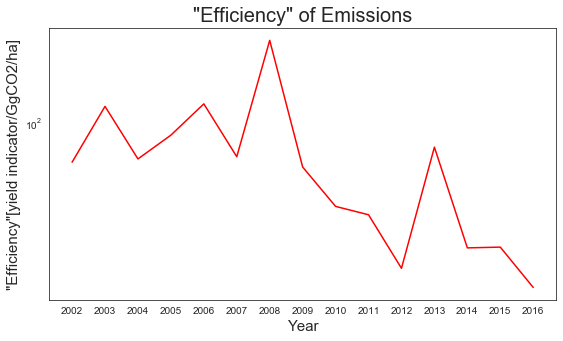

In [714]:
#plotting average efficiency factor over the years
figure = plt.figure(figsize = (20,5))
ax1 = figure.add_subplot(1,2,1)

ax1 = figure.add_subplot(1,2,1)
ax1.set_yscale('log')
ax1 = sns.lineplot(ee.index, ee['mean'], color = 'red')
ax1.set_title('"Efficiency" of Emissions', size = 20)
ax1.set_ylabel('"Efficiency"[yield indicator/GgCO2/ha]', size = 15)
ax1.set_xlabel('Year', size = 15)

plt.savefig('average_efficiency.png')

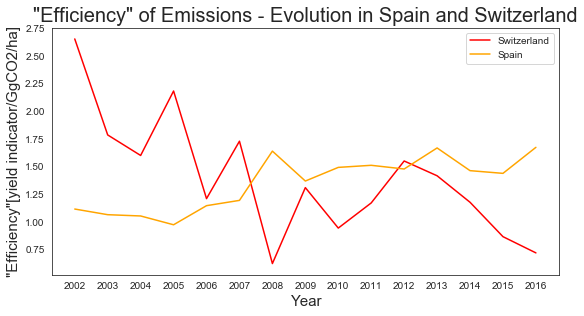

In [716]:
#plotting efficiency factor over the years for example countries
figure = plt.figure(figsize = (20,10))

ax1 = figure.add_subplot(2,2,1)
ax1.plot(ee.index, ee['Switzerland'], color = 'red')
ax1.plot(ee.index, ee['Spain'], color = 'orange')
ax1.legend(['Switzerland','Spain'])
ax1.set_title('"Efficiency" of Emissions - Evolution in Spain and Switzerland', size = 20)
ax1.set_ylabel('"Efficiency"[yield indicator/GgCO2/ha]', size = 15)
ax1.set_xlabel('Year', size = 15)

plt.savefig('efficiency_examples.png')

Here we can see that on average, our "efficiency" is decreasing, which is not good news. This being said, there are certain countries managing to improve. Further, as we saw that emissions and yields are not necessarily related, hopefully there is room for improvement.

## Conclusion : 

Overall, we have found the interesting result that the effectiveness of fertilizer may be decreasing overtime, and that increased environmental impacts due to fertilizer use are not necessarily associated with "better" yields.

This has interesting insights for our current agricultural system, as we need to be able to continue producing more food with less emissions and less fertilizer inputs in order to be less damaging to the environment.

Given the decreasing relationships between emissions and fertilizer use, this is a good starting point for arguing for an agricultural transition - and shows that this may not only be about reducing environmental impact, but also potentially improving agriculture, if our current methods are reaching their limits in terms of efficiency.